In [11]:
# Primary Goal: Abstract some generic "over all waves" baseline features
# E.g. al_scale/lr_scale
# Also generic immigration sentiment
# Maybe also Don't Knowness, Pol Attention, Being Wrong about Political Roles

# Secondary Goal: Transform features to have better distributions (norm/uniform)



# Initial pitch: Sparse PCA to split al from lr, factor analysis to remove major component for immig sentiment




In [12]:
# TODO:
# Compare results with weighted PCA/missing values
# wpca?

# Try gaussianize function instead of manual box-cox
# http://scottclowe.com/2016-03-12-boxcox-feature-gaussianisation/
# https://github.com/gregversteeg/gaussianize (doesn't look so good!)
# https://github.com/akalino/Gaussianize

In [13]:
dataset_name = "W14_comb"
df_list = [
           "BES_Panel",
           "BES_reduced_with_na",
#            "BESnumeric"
           "BES_reduced",
          ]

In [14]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

from IPython.display import display, display_html, HTML
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

import Jupyter_module_loader
from utility import *
import gaussian_kde


In [15]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
%matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()




In [16]:
global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

var_type (5692, 13)


In [17]:
memory_use(locs = locals().items())

           BES_reduced_with_na:   1.9GiB
                   BES_reduced: 552.5MiB
                     BES_Panel: 506.4MiB
                      var_type:   4.3MiB
             new_old_col_names: 288.1KiB
                cat_dictionary: 144.1KiB
             old_new_col_names: 144.1KiB
             BES_file_manifest:  42.4KiB
                      manifest:   1.7KiB
                          HTML:   1.0KiB


In [18]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components, display_pca_data, weighted_kde

In [19]:
def save_load_decomp(decomp, BES_decomp, BES_std, load_suff, save):
    if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
        decomp_method = str(decomp).split("(")[0] 
        subdir = output_subfolder + decomp_method
        fname = subdir+ os.sep + decomp_method
        # create dir, save decomp object, BES_decomp, BES_std    
        if not os.path.exists(subdir): os.makedirs(subdir)
        with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
        BES_decomp.to_msgpack(fname+".msgpack"        )
        BES_std.to_msgpack(   fname+"_std"+".msgpack" )

    else: # LOAD decomp results (default is SAVE)
        decomp_method = load_suff
        subdir = output_subfolder + os.sep + decomp_method    
        fname = subdir + os.sep + decomp_method
        if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
        # load decomp object, BES_decomp, BES_std, n_components
        with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
        BES_decomp = pd.read_msgpack(fname+".msgpack")
        BES_std    = pd.read_msgpack(fname+"_std"+".msgpack")
        n_components = decomp.components_.shape[0]
    return subdir

In [7]:
### Generalised Immigration Sentiment

In [42]:
def extra_sparse_factors(df, Treatment, alpha):
    output_subfolder = BES_output_folder + Treatment + os.sep
    if not os.path.exists( output_subfolder ):
        os.makedirs( output_subfolder )



    clean_feature_set_std = StandardScaler().fit_transform(df.values )
    BES_std = pd.DataFrame(      clean_feature_set_std,
                                 columns = df.columns,
                                 index   = df.index      )

    n_components = BES_std.shape[1]
    n_components = 2

    #decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
    decomp = SparsePCA(n_components = n_components, alpha = alpha)
    decomp_method = str(decomp).split("(")[0] 

    X_r = decomp.fit_transform(BES_std)

    BES_decomp = pd.DataFrame(   X_r,
                                 columns = range(0,n_components),
                                 index   = BES_std.index)

    load_suff = "SparsePCA"
    save = True # False => Load
    subdir = save_load_decomp(decomp, BES_decomp, BES_std, load_suff, save)

    # display_pca_data(n_components, decomp, BES_std)

    (BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                              BES_std.columns, BES_decomp, manifest, 
                                                              save_folder = subdir,  
                                                              show_first_x_comps= 4, show_histogram = False)
    BES_decomp.columns = comp_labels.values()
    return (BES_decomp, comp_labels, comp_dict)    

In [23]:
temp = BES_Panel[[x for x in BES_Panel.columns if "eumii" in x.lower()]]
temp2 = (temp == "immigration") | (temp == "Immigration")
temp3 = temp2.astype('float')
temp3.columns = [x+"_immigration" for x in temp3.columns]
eumii_vars = temp3

temp = BES_Panel[[x for x in BES_Panel.columns if re.match("miilabelW\d",x)]]
temp2 = (temp == "immigration") | (temp == "Immigration")
temp3 = temp2.astype('float')
temp3.columns = [x+"_immigration" for x in temp3.columns]
mii_vars = temp3

BES_immig = pd.concat( [ BES_reduced[[x for x in BES_reduced.columns if "imm" in x.lower()]].drop("miilabelW1_immigration",axis=1), eumii_vars, mii_vars], axis=1)
BES_immig = BES_immig.drop([x for x in BES_immig.columns if "discrim" in x], axis=1)
# fill NaNs in eumii/mii vars with mean
BES_immig[BES_immig.columns[BES_immig.isnull().any()]] = \
    BES_immig[BES_immig.columns[BES_immig.isnull().any()]].apply(lambda x: x.fillna(x.mean()))

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\sklearn\decomposition\sparse_pca.py:170: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique
Wall time: 1min 10s


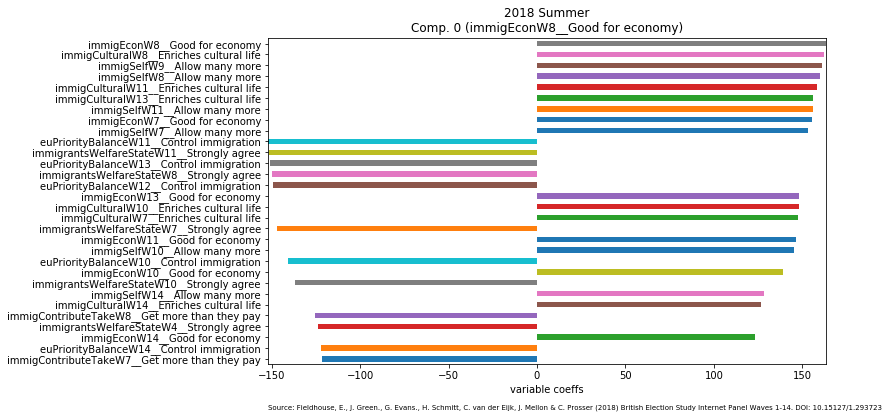

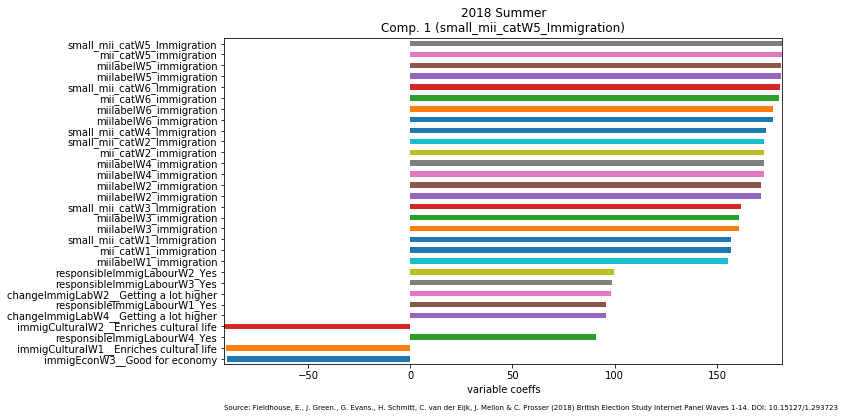

In [26]:
%%time
Treatment = "pan-dataset-values" + "_immigration"
(BES_decomp, comp_labels, comp_dict) = extra_sparse_factors(BES_immig, Treatment, alpha=32)


In [28]:
# comp_dict[0].sort_values(by='comp_absmag', ascending=False).iloc[0:50]

In [29]:
# BES_decomp[0].hist(bins=100);
genImmigSentiment = BES_decomp[0].copy()

In [22]:
## Generalised lr/al sentiments

In [30]:
# lr  leftRight, redistSelf, cutsTooFar
# al immigEcon, immigCultural, immigSelf, immigrantsWelfareState, overseasAid
al_lr_values = [x for x in BES_reduced.columns if re.match("(al|lr)\d|redistSelf",x)]
# al_lr_values = [x for x in BES_reduced.columns if re.match("(al\d|lr2|lr3|lr4|lr5)",x)]

                                                           #|govtHandouts|cutsTooFar|immigSelf|immigEcon|immigCultural|immigrantsWelfareState|overseasAid",x)]
BES_vals = BES_reduced[al_lr_values]

In [9]:
# Treatment = "pan-dataset-values" + "_allr_values" + "plus_redist"

# output_subfolder = BES_output_folder + Treatment + os.sep
# if not os.path.exists( output_subfolder ):
#     os.makedirs( output_subfolder )

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\sklearn\decomposition\sparse_pca.py:170: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique
Wall time: 10.9 s


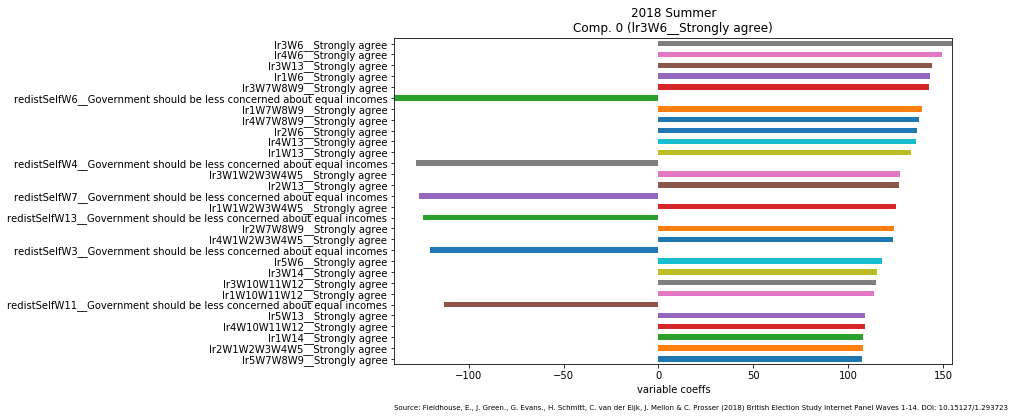

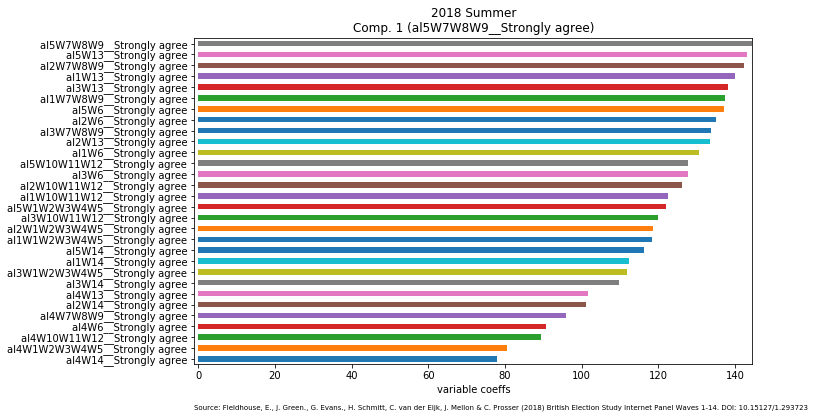

In [31]:
%%time
Treatment = "pan-dataset-values" + "_allr_values" + "plus_redist"
(BES_decomp, comp_labels, comp_dict) = extra_sparse_factors(BES_vals, Treatment, alpha=32)


In [40]:
# comp_dict[0].sort_values(by='comp_absmag',ascending=False)


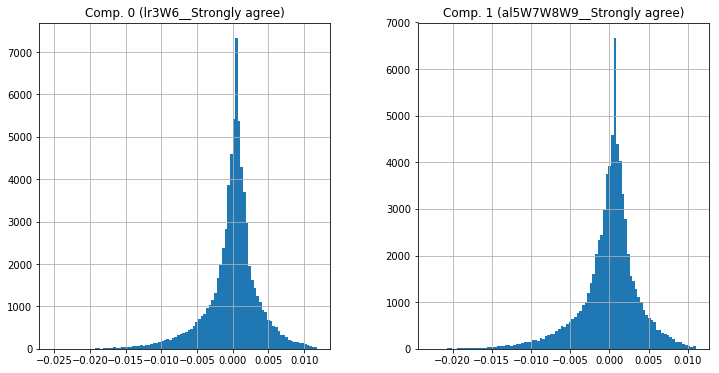

In [41]:
BES_decomp.hist(bins=100, figsize=(12,6));

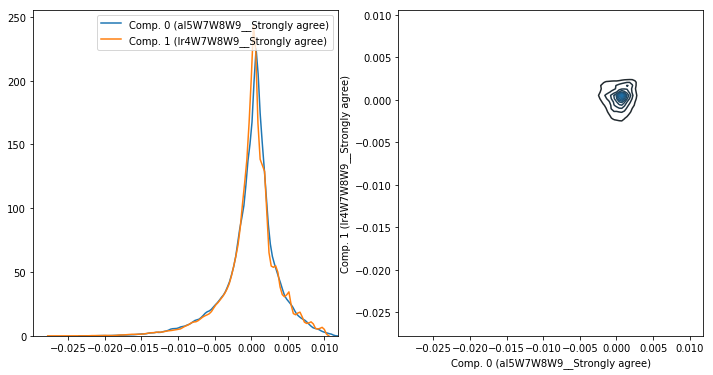

In [64]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharex=True)
sns.kdeplot(BES_decomp[comp_labels[0]], ax=ax1);
sns.kdeplot(BES_decomp[comp_labels[1]], ax=ax1);
sns.kdeplot(BES_decomp[comp_labels[0]],BES_decomp[comp_labels[1]],ax=ax2);


In [50]:
raw_gen_lr_vals_plus_redist = BES_decomp[comp_labels[0]].copy()
raw_gen_al_vals_plus_redist = BES_decomp[comp_labels[1]].copy()

In [25]:
##################################

In [53]:
al_lr_values = [x for x in BES_reduced.columns if re.match("(al|lr)\d",x)]
BES_vals = BES_reduced[al_lr_values]
Treatment = "pan-dataset-values" + "_allr_values" + "_standard"

output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

In [65]:
len(al_lr_values)

54

In [51]:
# al_lr_values = [x for x in BESnumeric.columns if re.match("(al|lr)\d",x)]
# BESnumeric[al_lr_values]

In [128]:
filename = dataset_name + "al_lr_values"

BESnumeric[al_lr_values].to_stata(BES_R_data_files + filename + ".dta")
display(filename)

'W14_combal_lr_values'

In [66]:
# provide datasets for imputation
al_values = [x for x in BES_reduced_with_na.columns if re.match("(al)\d",x)]
lr_values = [x for x in BES_reduced_with_na.columns if re.match("(lr)\d",x)]

filename = dataset_name + "al_values"
BES_reduced_with_na[al_values].to_stata(BES_R_data_files + filename + ".dta")

filename = dataset_name + "lr_values"
BES_reduced_with_na[lr_values].to_stata(BES_R_data_files + filename + ".dta")


C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\pandas\io\stata.py:2138: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    b'al1W6__Strongly agree'   ->   al1W6__Strongly_agree
    b'al2W6__Strongly agree'   ->   al2W6__Strongly_agree
    b'al3W6__Strongly agree'   ->   al3W6__Strongly_agree
    b'al4W6__Strongly agree'   ->   al4W6__Strongly_agree
    b'al5W6__Strongly agree'   ->   al5W6__Strongly_agree
    b'al1W13__Strongly agree'   ->   al1W13__Strongly_agree
    b'al2W13__Strongly agree'   ->   al2W13__Strongly_agree
    b'al3W13__Strongly agree'   ->   al3W13__Strongly_agree
    b'al4W13__Strongly agree'   ->   al4W13__Strongly_agree
    b'al5W13__Strongly agree'   ->   al5W13__Strongly_agree
    b'al1W14__Strongly agree'   ->   al1W14__Strongly_agree
    b'al2W14__Strongly agree'   ->   al2W14__Strongly_agree
    b'al3W14__Strongly agree'   ->   al3W14__Strongly_agree
    b'al4W14__Stron

In [ ]:
# provide datasets for imputation
al_values = [x for x in BES_reduced_with_na.columns if re.match("(al)\d",x)]
lr_values = [x for x in BES_reduced_with_na.columns if re.match("(lr)\d",x)]

filename = dataset_name + "al_values"
BES_reduced_with_na[al_values].to_stata(BES_R_data_files + filename + ".dta")

filename = dataset_name + "lr_values"
BES_reduced_with_na[lr_values].to_stata(BES_R_data_files + filename + ".dta")


In [99]:

# filename = dataset_name + "lr_values" + "_mice"
# filename = dataset_name + "lr_values" + "_Hmisc"
# filename = dataset_name + "lr_values" + "_missForest"
# BES_vals = pd.read_table(BES_R_data_files + filename + ".dta", delim_whitespace=True)

In [110]:
# BES_orig_vals = BES_reduced_with_na[lr_values]

In [183]:
values_dict = {"lr_values":lr_values, "al_values":al_values}


for value_key in values_dict.keys():
    
    filename_base = dataset_name + value_key
    BES_orig_vals = BES_reduced_with_na[ values_dict[value_key] ]

    for mi_type in ["_mice","_missForest","_Hmisc"]:
        print(value_key, mi_type)
        
        filename = filename_base + mi_type

        BES_vals = pd.read_csv(BES_R_data_files + filename + ".csv")
        BES_vals.drop(BES_vals.columns[0], axis=1, inplace=True)
        BES_vals.columns = [x.replace("Strongly_agree","Strongly agree") for x in BES_vals.columns]
        BES_vals = BES_vals[BES_orig_vals.columns]
        # BES_vals

        # sanity check!
        print( (BES_vals == BES_orig_vals).sum().sum() == BES_orig_vals.notnull().sum().sum() )

        BES_vals.to_msgpack(BES_R_data_files + filename + '.msgpack' )

lr_values _mice
True
lr_values _missForest
True
lr_values _Hmisc
True
al_values _mice
True
al_values _missForest
True
al_values _Hmisc
True


C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\sklearn\decomposition\sparse_pca.py:170: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique
Wall time: 6.79 s


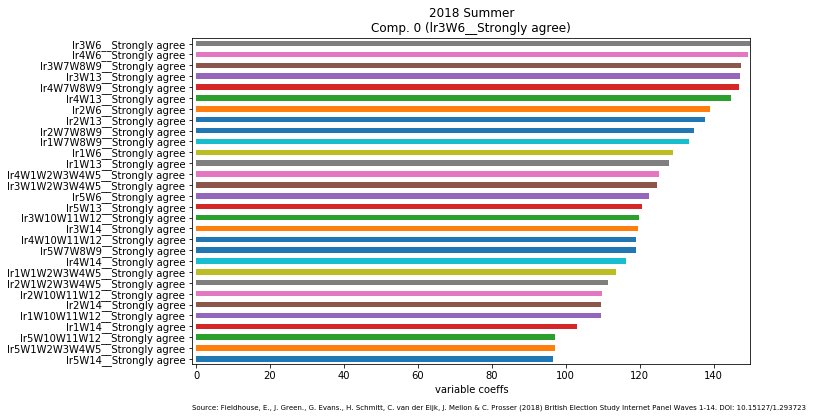

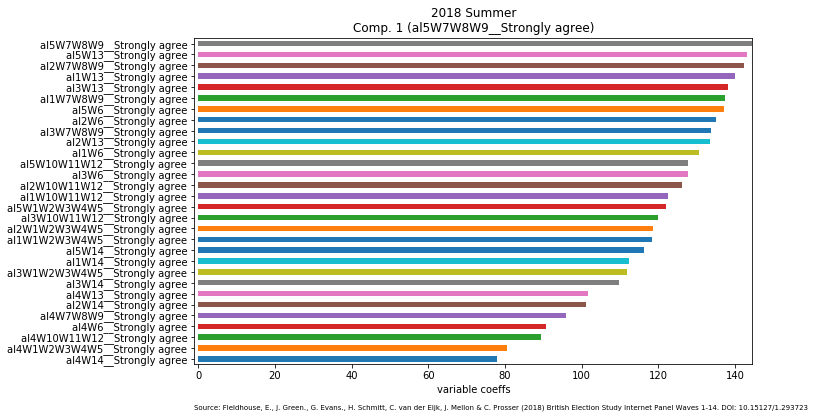

In [54]:
%%time
Treatment = "pan-dataset-values" + "_allr_values" + "_standard"
(BES_decomp, comp_labels, comp_dict) = extra_sparse_factors(BES_vals, Treatment, alpha=32)


In [56]:
raw_gen_lr_vals_standard = BES_decomp[comp_labels[0]].copy()
raw_gen_al_vals_standard = BES_decomp[comp_labels[1]].copy()

In [ ]:
##################################

In [57]:
al_lr_values = [x for x in BES_reduced.columns if re.match("(al\d|lr2|lr3|lr4|lr5)",x)]
BES_vals = BES_reduced[al_lr_values]


C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\sklearn\decomposition\sparse_pca.py:170: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique
Wall time: 4.57 s


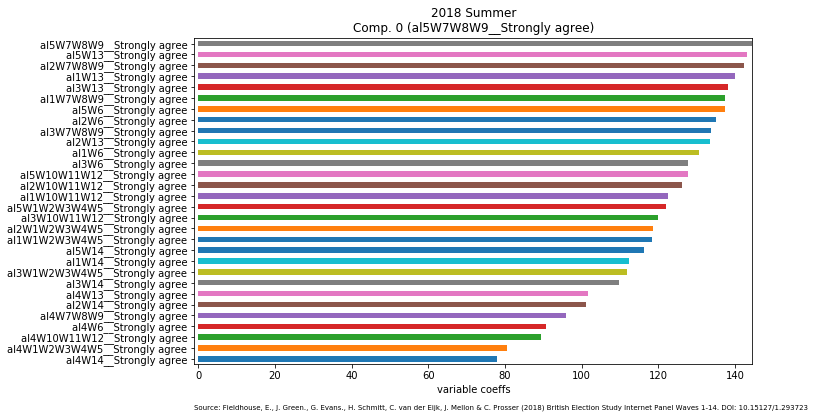

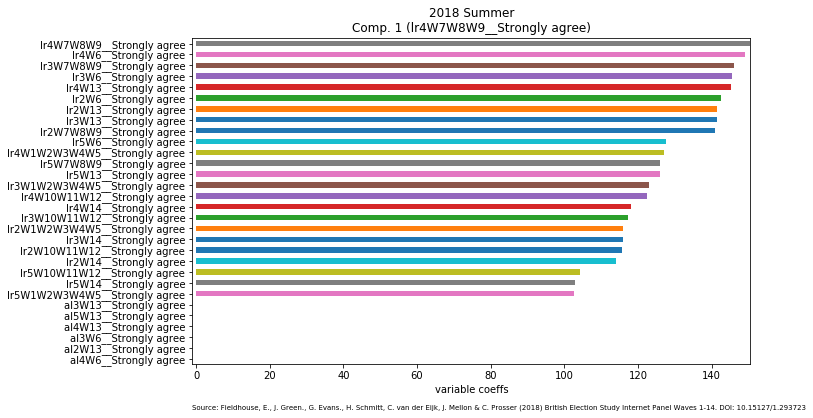

In [58]:
%%time
Treatment = "pan-dataset-values" + "_allr_values" + "_minus_lr1"
(BES_decomp, comp_labels, comp_dict) = extra_sparse_factors(BES_vals, Treatment, alpha=32)


In [59]:
raw_gen_lr_vals_minus_lr1 = BES_decomp[comp_labels[0]].copy()
raw_gen_al_vals_minus_lr1 = BES_decomp[comp_labels[1]].copy()

In [32]:
al_corr = BES_reduced.corrwith(BES_decomp[0])
lr_corr = BES_reduced.corrwith(BES_decomp[1])
diff_corr = al_corr.abs()-lr_corr.abs()

# lr  leftRight, redistSelf, cutsTooFar
# al immigEcon, immigCultural, immigSelf, immigrantsWelfareState, overseasAid

In [33]:
diff_corr.drop(al_lr_values).sort_values()

lr_scaleW7W8W9__Right                                                   -0.715280
lr_scaleW6__Right                                                       -0.646493
lr_scaleW13__Right                                                      -0.634577
lr_scaleW1W2W3W4W5__Right                                               -0.623492
lr_scaleW10W11W12__Right                                                -0.611343
lr_scaleW14__Right                                                      -0.577182
polForTheRichW4__Strongly agree                                         -0.427697
lr1W7W8W9__Strongly agree                                               -0.396369
polForTheRichW3__Strongly agree                                         -0.394225
polForTheRichW7__Strongly agree                                         -0.392517
renationaliseRailW11__Strongly agree                                    -0.379488
radicalW11__Strongly agree                                              -0.376627
lr1W6__Strongly 

In [75]:
from scipy import stats
def box_cox_normalise(ser):
    
    offset = 3
    # box cox lr_scale
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    x = ser.values +ser.values.min()+offset
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot against normal distribution')
    ax2 = fig.add_subplot(312)
    xt, _ = stats.boxcox(x)
    prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
    ax2.set_title('Probplot after Box-Cox transformation')
    ax3 = fig.add_subplot(313)
    xt_std = (xt-xt.mean())/xt.std()
    sns.kdeplot(xt_std, ax=ax3);
    sns.kdeplot(np.random.normal(size=len(xt_std)), ax=ax3);
    plt.suptitle(ser.name)
    return xt_std
    
    

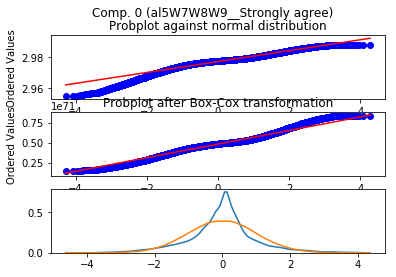

In [76]:
xt_std_lr = box_cox_normalise( BES_decomp[comp_labels[0]] )

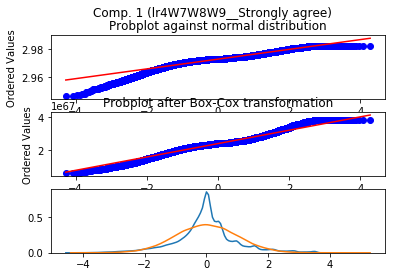

In [77]:
xt_std_al = box_cox_normalise( BES_decomp[comp_labels[1]] )

In [44]:
new_lr_corr = BES_reduced.corrwith(pd.DataFrame(xt_std_lr)[0])

In [45]:
(al_corr-new_lr_corr).sort_values()

conAngryW4_Yes                                                                                                     -0.048444
partyContact1W13_Yes                                                                                               -0.048288
conAngryW6_Yes                                                                                                     -0.048081
nonelecParticipation_2W6_Yes                                                                                       -0.044676
participation_4W13_Yes                                                                                             -0.043487
profile_religionW13_No, I do not regard myself as belonging to any particular religion.                            -0.043073
ldAngryW4_Yes                                                                                                      -0.043024
ldAngryW6_Yes                                                                                                      -0.041572


In [89]:
## problem here - can't guarantee underlying data has desired granularity to break into equal bins! 

granularity = 50
lr_uniform = pd.qcut( pd.Series(xt_std_lr).rank(method='first'), q=granularity, labels=range(0,granularity))
al_uniform = pd.qcut( pd.Series(xt_std_al).rank(method='first'), q=granularity, labels=range(0,granularity)) #, labels=range(0,granularity-2), duplicates='drop')

In [84]:
pd.Series(xt_std_lr).value_counts().head()

0.089052    1651
0.136880     504
0.499120     377
0.143860     230
0.219112     213
dtype: int64

In [113]:
lr_uniform

[17, 2, 12, 12, 8, ..., 13, 8, 6, 12, 4]
Length: 73703
Categories (19, int64): [0 < 1 < 2 < 3 ... 15 < 16 < 17 < 18]

In [91]:
al_uniform

0        48
1         1
2        39
3        20
4        12
5        46
6        48
7         4
8         6
9        13
10        3
11       23
12       11
13        1
14        2
15       41
16        1
17       49
18       48
19       34
20       10
21       29
22       42
23       43
24       12
25       38
26       46
27       24
28        5
29       47
         ..
73673    19
73674    28
73675    38
73676    28
73677     9
73678     9
73679    28
73680    36
73681    28
73682    33
73683    12
73684    16
73685    24
73686    28
73687    22
73688    33
73689     8
73690    21
73691    16
73692    33
73693    16
73694    38
73695    14
73696    38
73697    31
73698    19
73699    16
73700    28
73701    31
73702    22
Length: 73703, dtype: category
Categories (50, int64): [0 < 1 < 2 < 3 ... 46 < 47 < 48 < 49]

In [115]:
al_uniform.value_counts()

0     3880
1     3879
2     3879
3     3879
4     3879
5     3879
6     3885
7     3873
8     3879
9     7297
10     467
11    3938
12    3826
13    3867
14    3880
15    3878
16    3884
17    3874
18    3880
dtype: int64

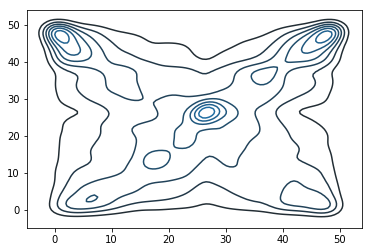

In [92]:
# slow!
%%time
sns.kdeplot(lr_uniform,al_uniform);

In [73]:
# # BES_small_data_files
BES_genImmSentiment = BES_Panel[["id"]].copy()
BES_genImmSentiment["genImmigSentiment"] = genImmigSentiment
BES_genImmSentiment["raw_gen_lr_vals"] = raw_gen_lr_vals
BES_genImmSentiment["raw_gen_al_vals"] = raw_gen_al_vals
BES_genImmSentiment["xt_std_lr"] = xt_std_lr
BES_genImmSentiment["xt_std_al"] = xt_std_al
BES_genImmSentiment["lr_uniform"] = list(lr_uniform)
BES_genImmSentiment["al_uniform"] = list(al_uniform)

# BES_genImmSentiment.to_csv(BES_small_data_files + "pan_dataset_values"+".csv", index=False)

NameError: name 'raw_gen_lr_vals' is not defined

In [ ]:
save_original_lr_breakdown

In [ ]:
# save_original_lr_breakdown = BES_vals.corrwith(BES_genImmSentiment["raw_gen_al_vals"]).sort_values()
BES_vals.corrwith(BES_genImmSentiment["raw_gen_al_vals"]).sort_values()

In [ ]:
# save_original_corr = BES_genImmSentiment.corr()

BES_genImmSentiment.corr()

In [ ]:
save_original_corr

In [48]:
## try another approach to Gaussianize a distribution

In [49]:
# ### test gaussianize
# # https://github.com/gregversteeg/gaussianize/blob/master/gaussianize.py
# DID NOT WORK!



# import gaussianize as g

# pan_dataset_values = pd.read_csv( BES_small_data_files + "pan_dataset_values.csv", encoding=encoding)

# pan_dataset_values["raw_gen_lr_vals"].hist(bins=100)

# out = g.Gaussianize()
# out.fit(pan_dataset_values["raw_gen_lr_vals"])  # Learn the parameters for the transformation
# lr_normed = out.transform(pan_dataset_values["raw_gen_lr_vals"])  # Transform x to y, where y should be normal
# pd.DataFrame(lr_normed).hist(bins=50)

# import gaussianize_2 as g_2

# out = g_2.Gaussianize()
# out.fit(pan_dataset_values["raw_gen_lr_vals"])
# lr_normed = out.transform(pan_dataset_values["raw_gen_lr_vals"])
# x_prime = out.normal_to_observed(lr_normed)  # Recover the initial distribution
# print(np.allclose(x_prime, pan_dataset_values["raw_gen_lr_vals"]))
# pd.DataFrame(lr_normed).hist(bins=50)

# ##### !!! Doens't finish !!!

In [144]:
[x for x in BES_reduced.columns if re.match("lr_scale",x)]

['lr_scaleW7W8W9__Right',
 'lr_scaleW6__Right',
 'lr_scaleW1W2W3W4W5__Right',
 'lr_scaleW10W11W12__Right',
 'lr_scaleW13__Right']

In [155]:
BES_reduced['al_scaleW13__Authoritarian'][~SocialLiberals].mean()

13.758160410352064

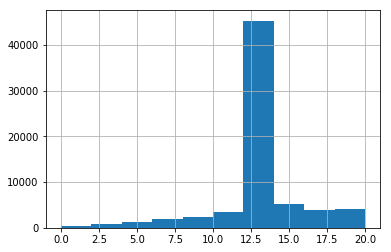

In [152]:
BES_reduced['al_scaleW13__Authoritarian'].hist()

In [ ]:
#######################################################################
###### Left-right for Social Liberals
#######################################################################

In [7]:
BES_genImmSentiment = pd.read_csv(BES_small_data_files + "pan_dataset_values"+".csv")

In [165]:
SocialLiberals      = BES_genImmSentiment['raw_gen_al_vals']<=BES_genImmSentiment['raw_gen_al_vals'].quantile(.25)
SocialConservatives = BES_genImmSentiment['raw_gen_al_vals']>=BES_genImmSentiment['raw_gen_al_vals'].quantile(.75)
# 17242
al_lr_values = [x for x in BES_reduced.columns if re.match("(al|lr)\d|redistSelf",x)]
#al_lr_values = [x for x in BES_reduced.columns if re.match("(al\d|lr2|lr3|lr4|lr5)",x)]

In [191]:
BES_immig = BES_reduced[al_lr_values][SocialLiberals]
# BES_immig = BES_reduced[al_lr_values][SocialConservatives]
lib = False
short = True
if lib==True and short==False:
    BES_immig = BES_reduced[SocialLiberals]
    Treatment = "pan-dataset-values" + "_socialliberals"
else:
    BES_immig = BES_reduced[SocialConservatives]
    Treatment = "pan-dataset-values" + "_socialconservatives"
    
if lib==True and short==True:
    BES_immig = BES_reduced[al_lr_values][SocialLiberals]
    Treatment = "pan-dataset-values" + "_socialliberals_short"
else:
    BES_immig = BES_reduced[al_lr_values][SocialConservatives]
    Treatment = "pan-dataset-values" + "_socialconservatives_short"


BES_immig[BES_immig.columns[BES_immig.isnull().any()]] = \
    BES_immig[BES_immig.columns[BES_immig.isnull().any()]].apply(lambda x: x.fillna(x.mean()))

In [192]:
# temp = BES_Panel[[x for x in BES_Panel.columns if "eumii" in x.lower()]]
# temp2 = (temp == "immigration") | (temp == "Immigration")
# temp3 = temp2.astype('float')
# temp3.columns = [x+"_immigration" for x in temp3.columns]
# eumii_vars = temp3

# temp = BES_Panel[[x for x in BES_Panel.columns if re.match("miilabelW\d",x)]]
# temp2 = (temp == "immigration") | (temp == "Immigration")
# temp3 = temp2.astype('float')
# temp3.columns = [x+"_immigration" for x in temp3.columns]
# mii_vars = temp3

# BES_immig = pd.concat( [ BES_reduced[[x for x in BES_reduced.columns if "imm" in x.lower()]].drop("miilabelW1_immigration",axis=1), eumii_vars, mii_vars], axis=1)
# BES_immig = BES_immig.drop([x for x in BES_immig.columns if "discrim" in x], axis=1)
# # fill NaNs in eumii/mii vars with mean
# BES_immig[BES_immig.columns[BES_immig.isnull().any()]] = \
#     BES_immig[BES_immig.columns[BES_immig.isnull().any()]].apply(lambda x: x.fillna(x.mean()))

Wall time: 3.03 s


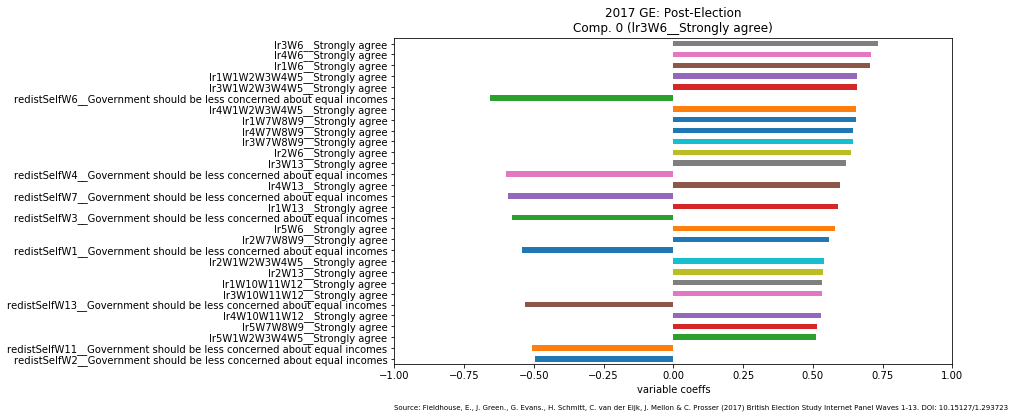

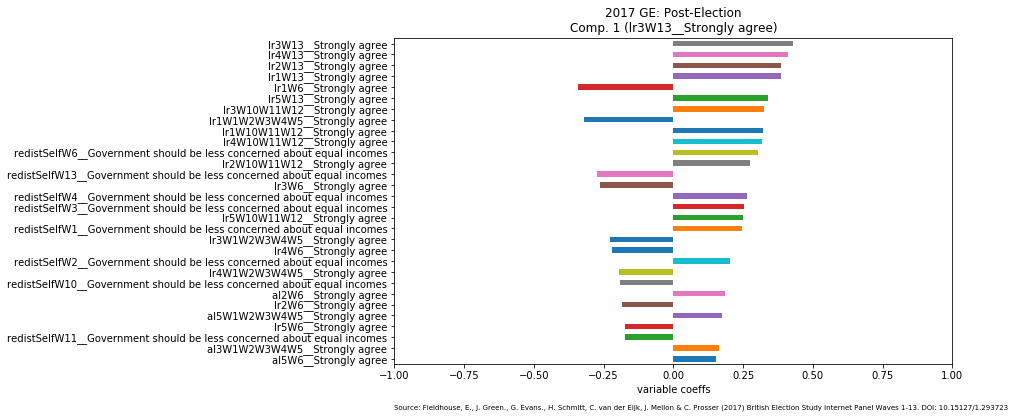

In [193]:
%%time


output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )
    
    

clean_feature_set_std = StandardScaler().fit_transform(BES_immig.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_immig.columns,
                             index   = BES_immig.index      )

n_components = BES_std.shape[1]
n_components = 2

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
#decomp = SparsePCA(n_components = n_components, alpha = 32)
decomp_method = str(decomp).split("(")[0] 

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_std.index)

load_suff = "SparsePCA"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 
    
# display_pca_data(n_components, decomp, BES_std)

(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_std.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

In [ ]:
# Well, that was not particularly helpful

In [8]:
BES_genImmSentiment = pd.read_csv(BES_small_data_files + "pan_dataset_values"+".csv")
SocialLiberals      = BES_genImmSentiment['raw_gen_al_vals']<=BES_genImmSentiment['raw_gen_al_vals'].quantile(.25)
SocialConservatives = BES_genImmSentiment['raw_gen_al_vals']>=BES_genImmSentiment['raw_gen_al_vals'].quantile(.75)
# 17242
al_lr_values = [x for x in BES_reduced_with_na.columns if re.match("(al|lr)\d|redistSelf",x)]

In [9]:
al_lr_valuesW13 = [x for x in BES_reduced_with_na.columns if re.match("((al|lr)\d|redistSelf)\w*W13",x)]

In [10]:
al_valuesW13 = [x for x in BES_reduced_with_na.columns if re.match("((al)\d)\w*W13",x)]

In [11]:
BES_reduced_with_na[al_lr_valuesW13][SocialConservatives].dropna().corr().loc[al_valuesW13].mean()

redistSelfW13__Government should be less concerned about equal incomes   -0.016586
lr1W13__Strongly agree                                                    0.028048
lr2W13__Strongly agree                                                    0.064328
lr3W13__Strongly agree                                                    0.048064
lr4W13__Strongly agree                                                    0.058363
lr5W13__Strongly agree                                                    0.076792
al1W13__Strongly agree                                                    0.323450
al2W13__Strongly agree                                                    0.247718
al3W13__Strongly agree                                                    0.328999
al4W13__Strongly agree                                                    0.216396
al5W13__Strongly agree                                                    0.329005
dtype: float64

In [12]:
BES_reduced_with_na[al_lr_valuesW13][SocialLiberals].dropna().corr().loc[al_valuesW13].mean()

redistSelfW13__Government should be less concerned about equal incomes    0.195166
lr1W13__Strongly agree                                                   -0.201596
lr2W13__Strongly agree                                                   -0.143971
lr3W13__Strongly agree                                                   -0.183392
lr4W13__Strongly agree                                                   -0.141524
lr5W13__Strongly agree                                                   -0.098304
al1W13__Strongly agree                                                    0.439438
al2W13__Strongly agree                                                    0.330912
al3W13__Strongly agree                                                    0.420742
al4W13__Strongly agree                                                    0.370541
al5W13__Strongly agree                                                    0.405166
dtype: float64

In [13]:
SocialSlice      = (BES_genImmSentiment['raw_gen_al_vals']<=BES_genImmSentiment['raw_gen_al_vals'].quantile(.1)) \
                    & (BES_genImmSentiment['raw_gen_al_vals']>=BES_genImmSentiment['raw_gen_al_vals'].quantile(0.0)) 

BES_reduced_with_na[al_lr_valuesW13][SocialSlice].dropna().corr().loc[al_valuesW13].mean()       


redistSelfW13__Government should be less concerned about equal incomes    0.160767
lr1W13__Strongly agree                                                   -0.155767
lr2W13__Strongly agree                                                   -0.110992
lr3W13__Strongly agree                                                   -0.148393
lr4W13__Strongly agree                                                   -0.109878
lr5W13__Strongly agree                                                   -0.077002
al1W13__Strongly agree                                                    0.412672
al2W13__Strongly agree                                                    0.299232
al3W13__Strongly agree                                                    0.396960
al4W13__Strongly agree                                                    0.354877
al5W13__Strongly agree                                                    0.375676
dtype: float64

In [14]:
BES_reduced_with_na[al_lr_valuesW13][SocialLiberals].dropna().var()

redistSelfW13__Government should be less concerned about equal incomes    7.604917
lr1W13__Strongly agree                                                    1.223570
lr2W13__Strongly agree                                                    0.904452
lr3W13__Strongly agree                                                    0.929453
lr4W13__Strongly agree                                                    1.084268
lr5W13__Strongly agree                                                    1.079793
al1W13__Strongly agree                                                    1.001059
al2W13__Strongly agree                                                    1.009075
al3W13__Strongly agree                                                    1.004671
al4W13__Strongly agree                                                    1.120777
al5W13__Strongly agree                                                    0.762334
dtype: float64

In [15]:
BES_reduced_with_na[al_lr_valuesW13][SocialConservatives].dropna().var()

redistSelfW13__Government should be less concerned about equal incomes    11.143916
lr1W13__Strongly agree                                                     1.571809
lr2W13__Strongly agree                                                     0.912194
lr3W13__Strongly agree                                                     1.146192
lr4W13__Strongly agree                                                     1.248605
lr5W13__Strongly agree                                                     0.948679
al1W13__Strongly agree                                                     0.406484
al2W13__Strongly agree                                                     0.806165
al3W13__Strongly agree                                                     0.367372
al4W13__Strongly agree                                                     1.015938
al5W13__Strongly agree                                                     0.339720
dtype: float64

In [16]:
# plt.figure(figsize=(12,8))
# g = sns.violinplot(x='profile_eurefvote_Leave the EU',
#                 y='likeCorbynW13__Strongly like',
#                 hue='generalElectionVoteW13_Labour', data=BES_reduced_with_na, cut=0, bw=.25)

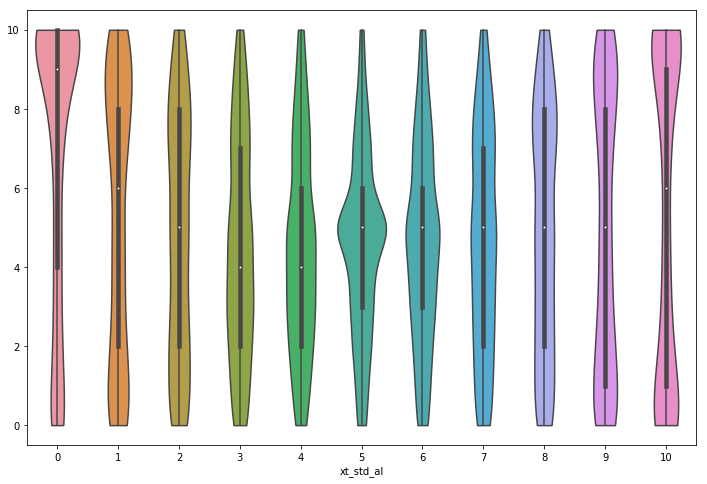

In [17]:
granularity = 11
lr_uniform = pd.qcut( BES_genImmSentiment['xt_std_lr'], q=granularity, labels=range(0,granularity))
al_uniform = pd.qcut( BES_genImmSentiment['xt_std_al'], q=granularity, labels=range(0,granularity)) #, labels=range(0,granularity-2), duplicates='drop')
plt.figure(figsize=(12,8))
sns.violinplot(al_uniform, lr_uniform.cat.codes, cut=0, bw=.25);

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


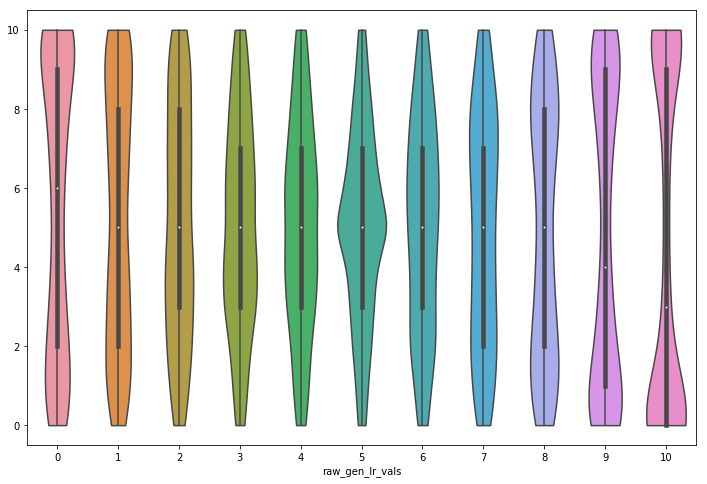

In [83]:
granularity = 11
lr_uniform = pd.qcut( BES_genImmSentiment['raw_gen_lr_vals'], q=granularity, labels=range(0,granularity))
al_uniform = pd.qcut( BES_genImmSentiment['raw_gen_al_vals'], q=granularity, labels=range(0,granularity)) #, labels=range(0,granularity-2), duplicates='drop')
plt.figure(figsize=(12,8))
sns.violinplot(lr_uniform, al_uniform.cat.codes, cut=0, bw=.25);

In [91]:
BES_genImmSentiment.head()

id  genImmigSentiment  raw_gen_lr_vals  raw_gen_al_vals  xt_std_lr  \
0   1          -0.005635         0.006900         0.005395   2.117757   
1   2           0.001292        -0.010506        -0.003629  -2.362559   
2   3           0.003045         0.001116         0.001943   0.225521   
3   4           0.000170         0.000091         0.001235  -0.061444   
4   5          -0.000032        -0.001446         0.000089  -0.467411   

   xt_std_al  lr_uniform  al_uniform  
0   1.604609          48          47  
1  -1.005104           0           6  
2   0.462197          32          37  
3   0.251536          21          32  
4  -0.073327          12          21

In [83]:
corr_lr = BES_reduced_with_na.corrwith(BES_genImmSentiment['raw_gen_lr_vals'])
corr_al = BES_reduced_with_na.corrwith(BES_genImmSentiment['raw_gen_al_vals'])
corr_im = BES_reduced_with_na.corrwith(BES_genImmSentiment['genImmigSentiment'])

In [85]:
corr_lr.sort_values()

lr_scaleW6__Right                                                        -0.889383
lr_scaleW13__Right                                                       -0.840828
lr_scaleW7W8W9__Right                                                    -0.813902
lr_scaleW1W2W3W4W5__Right                                                -0.785395
lr_scaleW10W11W12__Right                                                 -0.782219
redistSelfW6__Government should be less concerned about equal incomes    -0.729212
redistSelfW3__Government should be less concerned about equal incomes    -0.699893
redistSelfW4__Government should be less concerned about equal incomes    -0.693191
redistSelfW7__Government should be less concerned about equal incomes    -0.692221
redistSelfW13__Government should be less concerned about equal incomes   -0.660526
redistSelfW11__Government should be less concerned about equal incomes   -0.646792
redistSelfW1__Government should be less concerned about equal incomes    -0.641368
redi

In [86]:
corr_al.sort_values()

immigSelfW7__Allow many more                  -0.597744
asylumMoreW13__Many more                      -0.595683
immigSelfW8__Allow many more                  -0.593871
immigSelfW9__Allow many more                  -0.587545
asylumMoreW7__Many more                       -0.586978
asylumMoreW8__Many more                       -0.582097
immigSelfW11__Allow many more                 -0.568835
immigEconW7__Good for economy                 -0.566869
immigEconW3__Good for economy                 -0.566342
immigCulturalW7__Enriches cultural life       -0.562751
immigEconW8__Good for economy                 -0.560902
immigSelfW10__Allow many more                 -0.557920
immigCulturalW3__Enriches cultural life       -0.557780
immigCulturalW8__Enriches cultural life       -0.553242
immigCulturalW13__Enriches cultural life      -0.551894
immigEconW4__Good for economy                 -0.547163
immigCulturalW2__Enriches cultural life       -0.542465
immigEconW2__Good for economy                 -0

In [87]:
corr_im.sort_values()

euPriorityBalanceW11__Control immigration        -0.794756
euPriorityBalanceW13__Control immigration        -0.791487
euPriorityBalanceW10__Control immigration        -0.776277
immigrantsWelfareStateW8__Strongly agree         -0.772673
euPriorityBalanceW12__Control immigration        -0.770661
immigrantsWelfareStateW11__Strongly agree        -0.767041
immigrantsWelfareStateW7__Strongly agree         -0.758758
happyEULeaveW11__Extremely happy                 -0.741846
immigrantsWelfareStateW10__Strongly agree        -0.738500
EUIntegrationSelfW11__Protect our independence   -0.727523
happyEULeaveW9__Extremely happy                  -0.722108
happyEULeaveW10__Extremely happy                 -0.720937
euUndermineIdentityW8__Strongly agree            -0.714964
EUIntegrationSelfW13__Protect our independence   -0.714541
ukCoopMovementW8__Bad for Britain                -0.706519
EUIntegrationSelfW10__Protect our independence   -0.703749
EUIntegrationSelfW9__Protect our independence    -0.7037

In [18]:
# al_lr_valuesW13 = 
lr_values = [x for x in BES_reduced_with_na.columns if re.match("((lr)\d|redistSelf)\w*W13",x)]

In [19]:
al_uniform.value_counts()

5     6241
4     6240
10    6239
9     6239
7     6239
3     6239
1     6239
0     6239
8     6238
2     6238
6     6234
Name: raw_gen_al_vals, dtype: int64

In [20]:
# sns.violinplot(BES_reduced_with_na[lr_values[0]])


# al_uniform==0

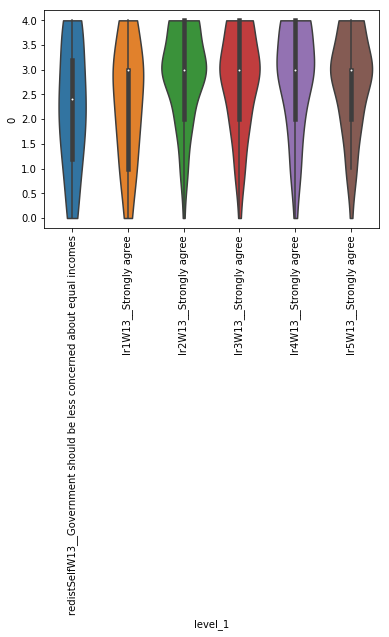

In [21]:
lr_vals = BES_reduced_with_na[lr_values].copy()
redist_var = [x for x in lr_vals.columns if "redist" in x]
lr_vals[redist_var] = (10-lr_vals[redist_var])/2.5

sns.violinplot(x = 'level_1', y=0, data = lr_vals.stack().reset_index(), cut=0, bw=.5 )
plt.xticks( rotation =90);

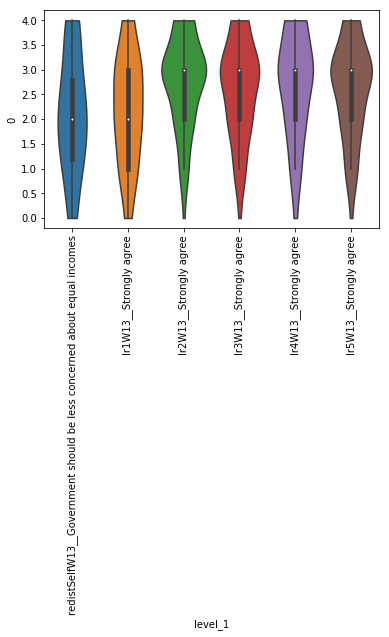

In [22]:
lr_vals = BES_reduced_with_na[lr_values][al_uniform==4].copy()
redist_var = [x for x in lr_vals.columns if "redist" in x]
lr_vals[redist_var] = (10-lr_vals[redist_var])/2.5

sns.violinplot(x = 'level_1', y=0, data = lr_vals.stack().reset_index(), cut=0, bw=.5 )
plt.xticks( rotation =90);

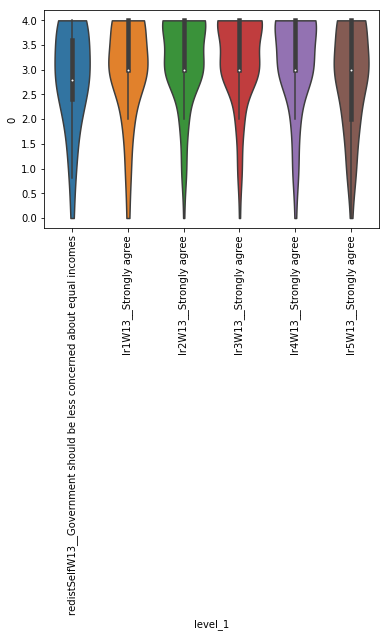

In [23]:
lr_vals = BES_reduced_with_na[lr_values][al_uniform==0].copy()
redist_var = [x for x in lr_vals.columns if "redist" in x]
lr_vals[redist_var] = (10-lr_vals[redist_var])/2.5

sns.violinplot(x = 'level_1', y=0, data = lr_vals.stack().reset_index(), cut=0, bw=.5 )
plt.xticks( rotation =90);

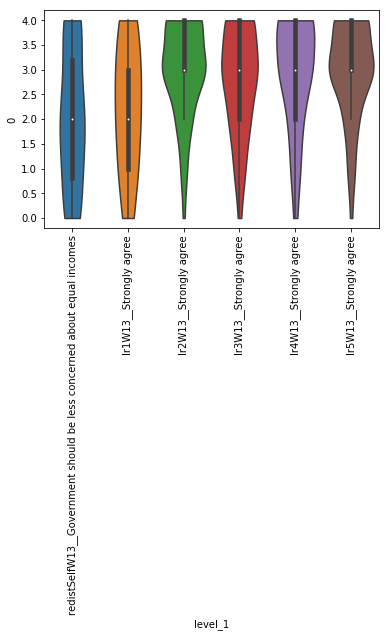

In [24]:
lr_vals = BES_reduced_with_na[lr_values][al_uniform==10].copy()
redist_var = [x for x in lr_vals.columns if "redist" in x]
lr_vals[redist_var] = (10-lr_vals[redist_var])/2.5

sns.violinplot(x = 'level_1', y=0, data = lr_vals.stack().reset_index(), cut=0, bw=.5 )
plt.xticks( rotation =90);

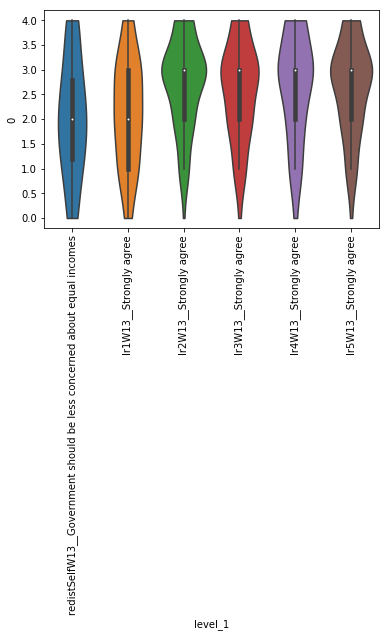

In [25]:
lr_vals = BES_reduced_with_na[lr_values][al_uniform==5].copy()
redist_var = [x for x in lr_vals.columns if "redist" in x]
lr_vals[redist_var] = (10-lr_vals[redist_var])/2.5

sns.violinplot(x = 'level_1', y=0, data = lr_vals.stack().reset_index(), cut=0, bw=.5 )
plt.xticks( rotation =90);

In [27]:
al_values = [x for x in BES_reduced_with_na.columns if re.match("((al)\d)\w*W13",x)]
al_vals = BES_reduced_with_na[al_values].copy()
al_mask = al_vals.notnull().all(axis=1)
al_vals = StandardScaler().fit_transform(al_vals[al_mask].values )

al_vals = pd.DataFrame(      al_vals,
                             columns = BES_reduced_with_na[al_values].dropna().columns,
                             index   = BES_reduced_with_na[al_values].dropna().index      )


In [28]:

lr_vals = BES_reduced_with_na[lr_values].copy()
redist_var = [x for x in lr_vals.columns if "redist" in x]
lr_vals[redist_var] = (10-lr_vals[redist_var])/2.5
lr_mask = lr_vals.notnull().all(axis=1)
lr_vals = StandardScaler().fit_transform(lr_vals[lr_mask].values )

lr_vals = pd.DataFrame(      lr_vals,
                             columns = BES_reduced_with_na[lr_values].dropna().columns,
                             index   = BES_reduced_with_na[lr_values].dropna().index      )

lr_val_names = list(lr_vals.columns)
lr_val_names[0] = lr_val_names[0].replace('Government should be less concerned about equal incomes',
                        'EqualiseIncomes')
lr_vals.columns = lr_val_names
lr_vals.columns

Index(['redistSelfW13__EqualiseIncomes', 'lr1W13__Strongly agree',
       'lr2W13__Strongly agree', 'lr3W13__Strongly agree',
       'lr4W13__Strongly agree', 'lr5W13__Strongly agree'],
      dtype='object')

In [70]:
Treatment = "pan-dataset-values"

output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

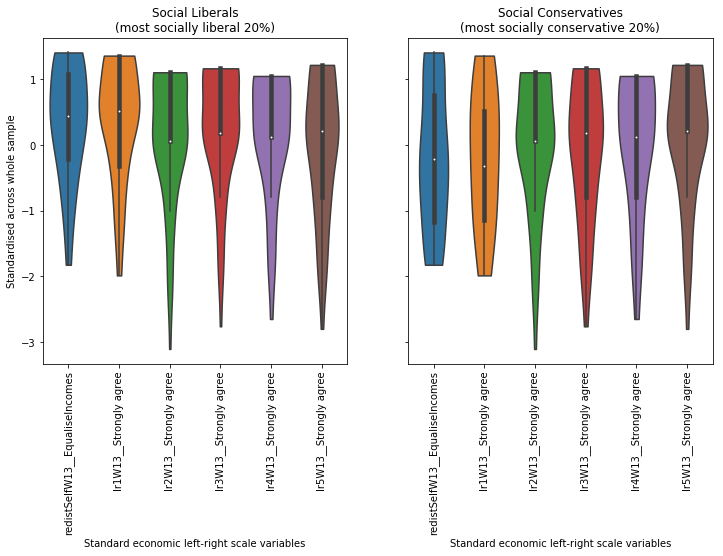

In [57]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
sns.violinplot(ax=ax1, x = 'level_1', y=0, data = lr_vals[(al_uniform<2)[lr_mask]].stack().reset_index(), cut=0, bw=.5)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('Standardised across whole sample');
ax1.set_xlabel('Standard economic left-right scale variables');
ax1.set_title("Social Liberals\n(most socially liberal 20%)");

sns.violinplot(ax=ax2, x = 'level_1', y=0, data = lr_vals[(al_uniform>8)[lr_mask]].stack().reset_index(), cut=0, bw=.5 )
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylabel('');
ax2.set_xlabel('Standard economic left-right scale variables');
ax2.set_title("Social Conservatives\n(most socially conservative 20%)");
"pan_dataset_values"
plt.savefig(output_subfolder + "something_about_redistribution" + ".png", bbox_inches='tight')

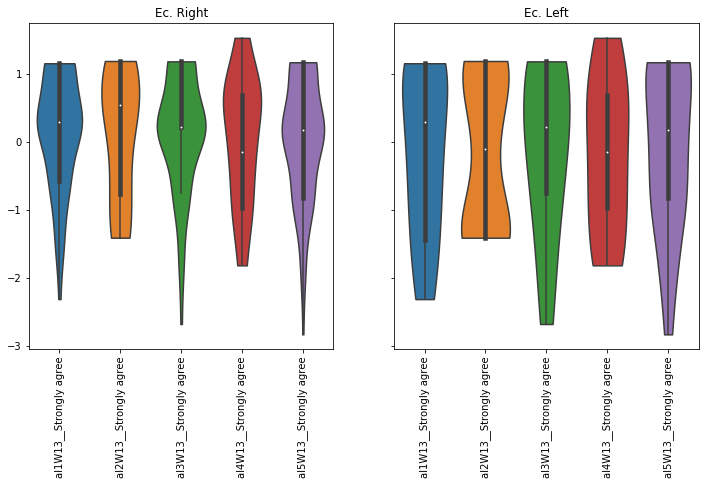

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
sns.violinplot(ax=ax1, x = 'level_1', y=0, data = al_vals[(lr_uniform<2)[al_mask]].stack().reset_index(), cut=0, bw=.5)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('');
ax1.set_xlabel('');
ax1.set_title("Ec. Right");

sns.violinplot(ax=ax2, x = 'level_1', y=0, data = al_vals[(lr_uniform>8)[al_mask]].stack().reset_index(), cut=0, bw=.5 )
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylabel('');
ax2.set_xlabel('');
ax2.set_title("Ec. Left");
plt.savefig(output_subfolder + "something_about_redistribution" + ".png", bbox_inches='tight')

In [ ]:
## redo

In [88]:
# BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if "education" in x]].notnull().sum()

In [64]:
NoUni = BES_reduced_with_na['anyUniW13__Yes, I graduated from higher education']==0.0
SomeUni = BES_reduced_with_na['anyUniW13__Yes, I graduated from higher education']>0

In [70]:
# lr_vals[(al_uniform<2)[lr_mask]][NoUni[lr_mask]]

C:\Users\Marios\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
C:\Users\Marios\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


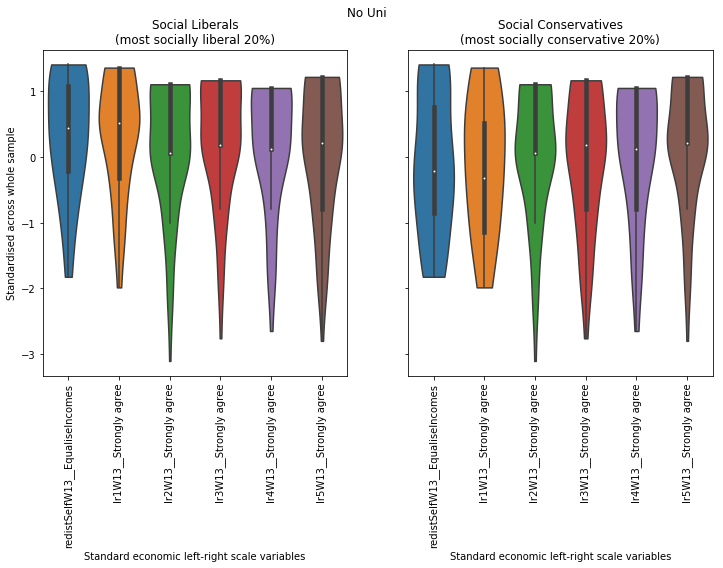

In [94]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
sns.violinplot(ax=ax1, x = 'level_1', y=0, data = lr_vals[(al_uniform<2)[lr_mask]][NoUni[lr_mask]].stack().reset_index(),
               cut=0, bw=.5, scale='count')
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('Standardised across whole sample');
ax1.set_xlabel('Standard economic left-right scale variables');
ax1.set_title("Social Liberals\n(most socially liberal 20%)");

sns.violinplot(ax=ax2, x = 'level_1', y=0, data = lr_vals[(al_uniform>8)[lr_mask]][NoUni[lr_mask]].stack().reset_index(),
               cut=0, bw=.5, scale='count' )
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylabel('');
ax2.set_xlabel('Standard economic left-right scale variables');
ax2.set_title("Social Conservatives\n(most socially conservative 20%)");
"pan_dataset_values"
plt.savefig(output_subfolder + "something_about_redistribution_no_uni" + ".png", bbox_inches='tight')
plt.suptitle("No Uni");

C:\Users\Marios\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
C:\Users\Marios\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


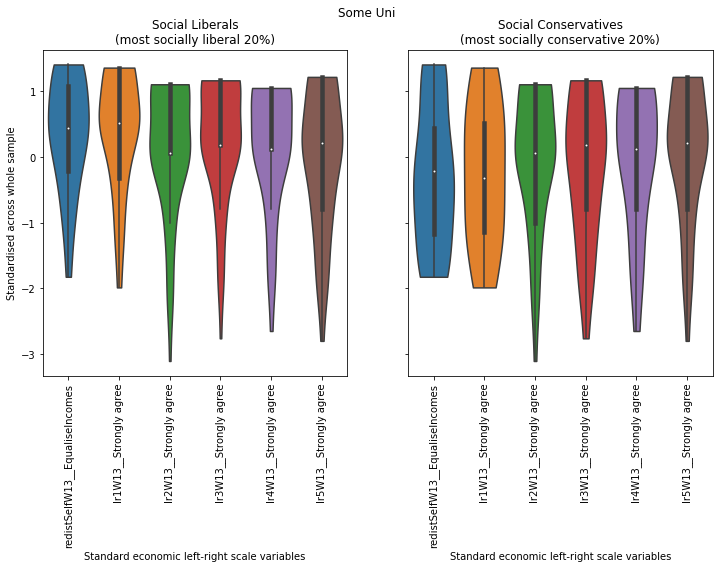

In [95]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
sns.violinplot(ax=ax1, x = 'level_1', y=0, data = lr_vals[(al_uniform<2)[lr_mask]][SomeUni[lr_mask]].stack().reset_index(),
               cut=0, bw=.5, scale='count')
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('Standardised across whole sample');
ax1.set_xlabel('Standard economic left-right scale variables');
ax1.set_title("Social Liberals\n(most socially liberal 20%)");

sns.violinplot(ax=ax2, x = 'level_1', y=0, data = lr_vals[(al_uniform>8)[lr_mask]][SomeUni[lr_mask]].stack().reset_index(),
               cut=0, bw=.5, scale='count' )
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylabel('');
ax2.set_xlabel('Standard economic left-right scale variables');
ax2.set_title("Social Conservatives\n(most socially conservative 20%)");
"pan_dataset_values"
plt.savefig(output_subfolder + "something_about_redistribution_some_uni" + ".png", bbox_inches='tight')
plt.suptitle("Some Uni");

C:\Users\Marios\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Marios\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


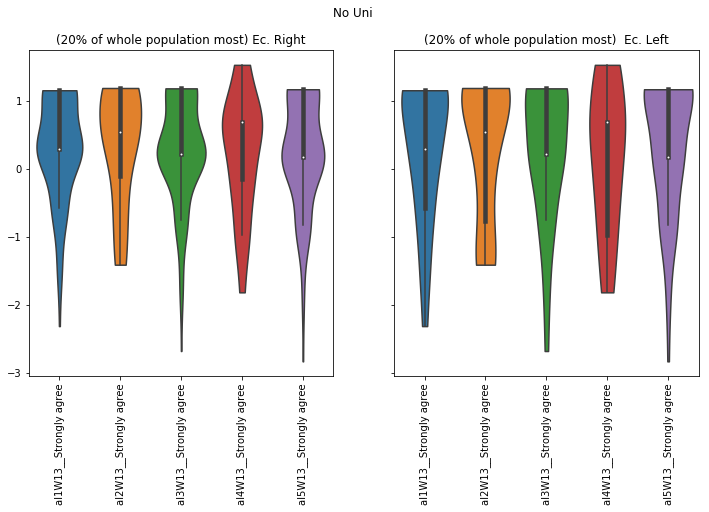

In [100]:



f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
sns.violinplot(ax=ax1, x = 'level_1', y=0, data = al_vals[(lr_uniform<2)[al_mask]][NoUni[al_mask]].stack().reset_index(), cut=0, bw=.5)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('');
ax1.set_xlabel('');
ax1.set_title("(20% of whole population most) Ec. Right");

sns.violinplot(ax=ax2, x = 'level_1', y=0, data = al_vals[(lr_uniform>8)[al_mask]][NoUni[al_mask]].stack().reset_index(), cut=0, bw=.5 )
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylabel('');
ax2.set_xlabel('');
ax2.set_title("(20% of whole population most)  Ec. Left");
plt.suptitle("No Uni");
plt.savefig(output_subfolder + "something_about_redistribution_no_uni_al_vals" + ".png", bbox_inches='tight')

C:\Users\Marios\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\Marios\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


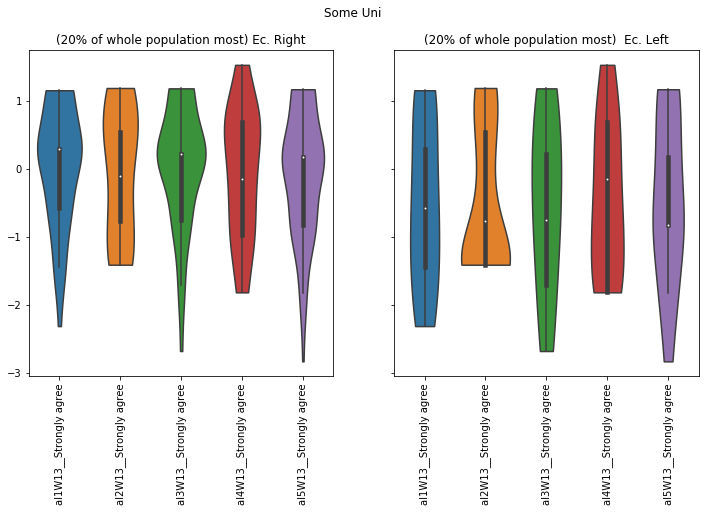

In [101]:

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
sns.violinplot(ax=ax1, x = 'level_1', y=0, data = al_vals[(lr_uniform<2)[al_mask]][SomeUni[al_mask]].stack().reset_index(), cut=0, bw=.5)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('');
ax1.set_xlabel('');
ax1.set_title("(20% of whole population most) Ec. Right");

sns.violinplot(ax=ax2, x = 'level_1', y=0, data = al_vals[(lr_uniform>8)[al_mask]][SomeUni[al_mask]].stack().reset_index(), cut=0, bw=.5 )
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylabel('');
ax2.set_xlabel('');
ax2.set_title("(20% of whole population most)  Ec. Left");
plt.suptitle("Some Uni");
plt.savefig(output_subfolder + "something_about_redistribution_some_uni_al_vals" + ".png", bbox_inches='tight')

In [80]:
lr_vals[(al_uniform<2)[lr_mask]][NoUni[lr_mask]]

C:\Users\Marios\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


redistSelfW13__EqualiseIncomes  lr1W13__Strongly agree  \
116                          0.438763                1.359369   
171                         -0.529920                0.523735   
194                          1.407446                1.359369   
215                          0.438763                1.359369   
232                          1.084552                0.523735   
284                         -0.852814               -1.983167   
287                         -0.852814               -1.147533   
422                          1.407446                1.359369   
437                         -0.529920                0.523735   
459                         -0.529920               -0.311899   
532                          0.438763                1.359369   
556                         -0.207025                0.523735   
615                          0.438763                0.523735   
675                          0.438763               -0.311899   
699                         -0.852814               -1.983167   
757                          0.438763               -0.311899   
767                          1.407446                1.359369   
771                         -0.852814                0.523735   
779                         -0.207025                0.523735   
860                          0.115869               -0.311899   
882                         -0.852814               -1.147533   
941                         -1.175709               -1.147533   
955                          0.438763                1.359369   
1115                        -0.207025               -0.311899   
1174                        -0.529920               -1.147533   
1198                        -1.821497               -1.147533   
1203                         1.407446                1.359369   
1212                         1.407446                1.359369   
1216                        -0.529920               -1.147533   
1301                         1.407446                1.359369   
...                               ...                     ...   
66805                       -0.852814               -1.147533   
66970                       -0.207025               -0.311899   
66988                        0.438763               -0.311899   
67078                        1.407446                1.359369   
67138                        1.407446                0.523735   
67161                        1.084552                0.523735   
67213                        1.407446                1.359369   
67217                        1.407446                1.359369   
67345                       -0.852814               -0.311899   
67376                        1.084552                1.359369   
67433                        1.407446                1.359369   
67437                        1.407446                1.359369   
67445                       -0.207025               -1.147533   
67567                       -0.852814               -0.311899   
67579                        1.407446                1.359369   
67589                        1.407446               -1.983167   
67651                        0.438763                0.523735   
67678                        0.115869                0.523735   
67757                        1.407446               -1.983167   
67822                        1.407446                1.359369   
68022                        1.407446               -1.147533   
68039                       -0.207025                0.523735   
68106                        0.438763                0.523735   
68217                        0.115869                0.523735   
68439                        1.407446                1.359369   
68441                        0.761658                0.523735   
68504                        0.438763                0.523735   
68521                        1.084552                0.523735   
68580                       -1.175709               -1.147533   
68610                        0.761658     

In [99]:
print( BES_reduced_with_na['lr_scaleW13__Right'].corr(BES_reduced_with_na['al_scaleW13__Authoritarian']) )
print( BES_reduced_with_na['lr_scaleW13__Right'][NoUni].corr(BES_reduced_with_na['al_scaleW13__Authoritarian'][NoUni]) )
print( BES_reduced_with_na['lr_scaleW13__Right'][SomeUni].corr(BES_reduced_with_na['al_scaleW13__Authoritarian'][SomeUni])) 

0.121370177157
0.00544567922949
0.204540728795


(0, 20)

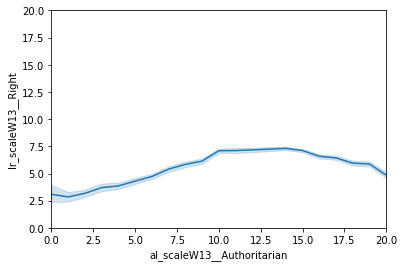

In [30]:
sns.lineplot(x=BES_reduced_with_na['al_scaleW13__Authoritarian'], y=BES_reduced_with_na['lr_scaleW13__Right'])
plt.xlim(0,20);
plt.ylim(0,20);

(0, 20)

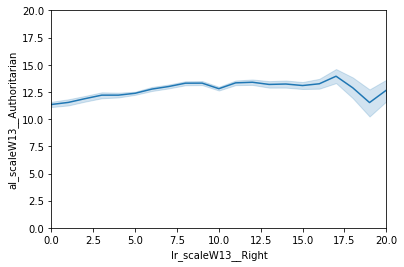

In [31]:
sns.lineplot(y=BES_reduced_with_na['al_scaleW13__Authoritarian'], x=BES_reduced_with_na['lr_scaleW13__Right'])
plt.xlim(0,20);
plt.ylim(0,20);

In [71]:
output_subfolder

'../BES_analysis_output/pan-dataset-values\\'

In [72]:
redistribution_subfolder = output_subfolder + "redistribution" + os.sep

if not os.path.exists( redistribution_subfolder ):
    os.makedirs( redistribution_subfolder )

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


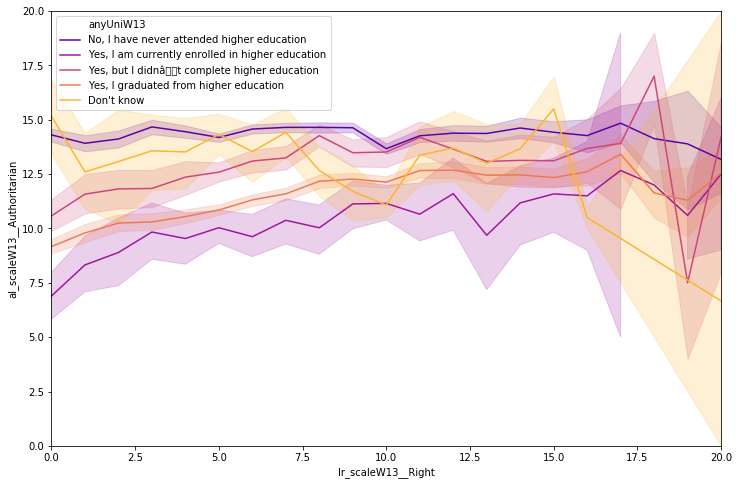

In [73]:
plt.figure(figsize=(12,8))
sns.lineplot(y=BES_reduced_with_na['al_scaleW13__Authoritarian'],
             x=BES_reduced_with_na['lr_scaleW13__Right'],
             hue = BES_Panel['anyUniW13'],
             palette = "plasma")
plt.xlim(0,20);
plt.ylim(0,20);
plt.savefig(redistribution_subfolder + "al_scale_by_lr_scale_by_anyUni" + ".png", bbox_inches='tight')

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


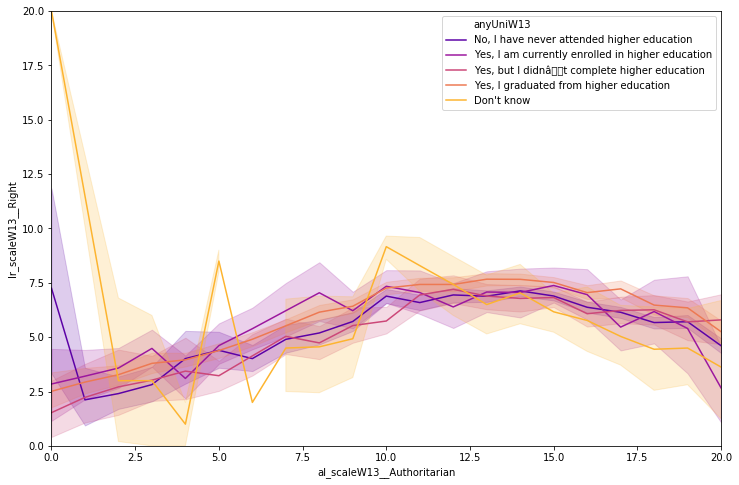

In [74]:
plt.figure(figsize=(12,8))
sns.lineplot(x=BES_reduced_with_na['al_scaleW13__Authoritarian'],
             y=BES_reduced_with_na['lr_scaleW13__Right'],
             hue = BES_Panel['anyUniW13'],
             palette = "plasma")
plt.xlim(0,20);
plt.ylim(0,20);
plt.savefig(redistribution_subfolder + "lr_scale_by_al_scale_by_anyUni" + ".png", bbox_inches='tight')

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


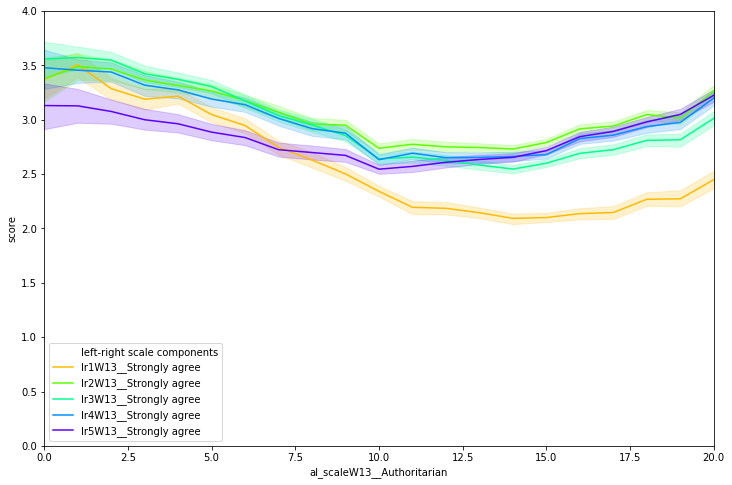

In [75]:
lr_values = [x for x in BES_reduced_with_na.columns if re.match("((lr)\d)\w*W13",x)] # |redistSelf

lr_vals_by_al = BES_reduced_with_na[ lr_values + ['al_scaleW13__Authoritarian'] ].copy().set_index('al_scaleW13__Authoritarian').dropna()
lr_vals_by_al = lr_vals_by_al.stack().reset_index()
lr_vals_by_al.columns = ['al_scaleW13__Authoritarian', "left-right scale components", "score"]


plt.figure(figsize=(12,8))
sns.lineplot(y="score",
             x='al_scaleW13__Authoritarian',
             hue = "left-right scale components",
             data = lr_vals_by_al,
             palette = 'gist_rainbow')
plt.xlim(0,20);
plt.ylim(0,4);
plt.savefig(redistribution_subfolder + "lr_vars_by_al_scale" + ".png", bbox_inches='tight')

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


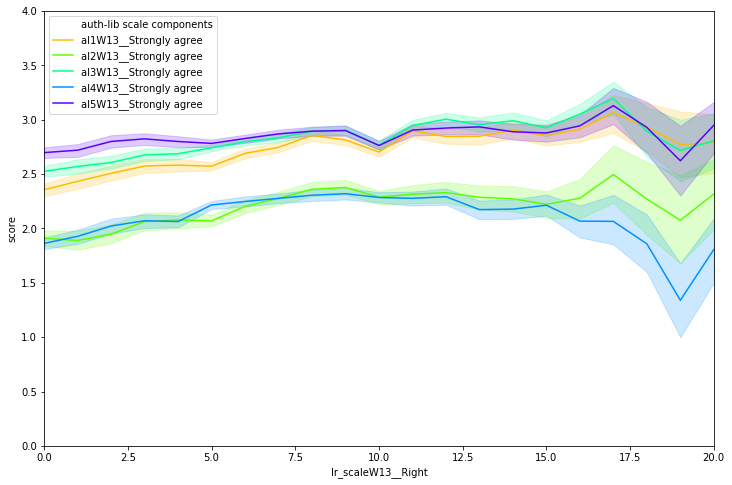

In [76]:
al_values = [x for x in BES_reduced_with_na.columns if re.match("((al)\d)\w*W13",x)] # |redistSelf
x_scale = 'lr_scaleW13__Right'

al_vals_by_lr = BES_reduced_with_na[ al_values + [x_scale] ].copy().set_index(x_scale).dropna()
al_vals_by_lr = al_vals_by_lr.stack().reset_index()
al_vals_by_lr.columns = [x_scale, "auth-lib scale components", "score"]


plt.figure(figsize=(12,8))
sns.lineplot(y="score",
             x=x_scale,
             hue = "auth-lib scale components",
             data = al_vals_by_lr,
             palette = 'gist_rainbow')
plt.xlim(0,20);
plt.ylim(0,4);
plt.savefig(redistribution_subfolder + "al_vars_by_lr_scale" + ".png", bbox_inches='tight')

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


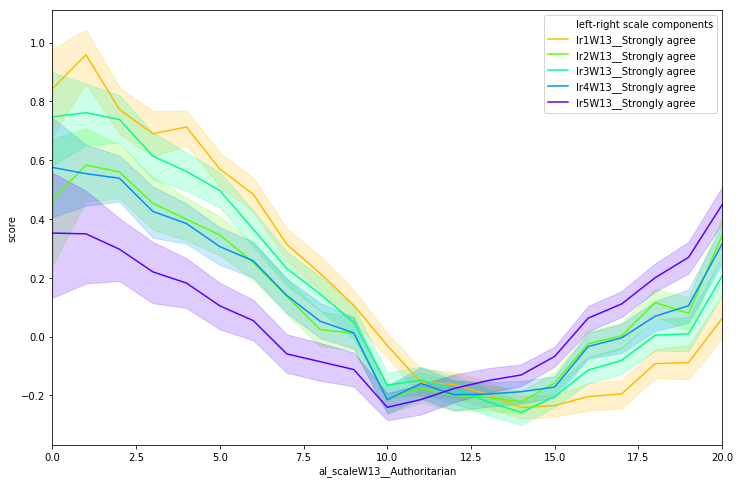

In [77]:
lr_values = [x for x in BES_reduced_with_na.columns if re.match("((lr)\d)\w*W13",x)] # |redistSelf

lr_vals_by_al = BES_reduced_with_na[ lr_values + ['al_scaleW13__Authoritarian'] ].copy().set_index('al_scaleW13__Authoritarian').dropna()
# standardise
lr_vals_by_al = (lr_vals_by_al-lr_vals_by_al.mean()) / lr_vals_by_al.std()
lr_vals_by_al = lr_vals_by_al.stack().reset_index()
lr_vals_by_al.columns = ['al_scaleW13__Authoritarian', "left-right scale components", "score"]


plt.figure(figsize=(12,8))
sns.lineplot(y="score",
             x='al_scaleW13__Authoritarian',
             hue = "left-right scale components",
             data = lr_vals_by_al,
             palette = 'gist_rainbow')
plt.xlim(0,20);
plt.savefig(redistribution_subfolder + "lr_vars_by_al_scale_standardised" + ".png", bbox_inches='tight')

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


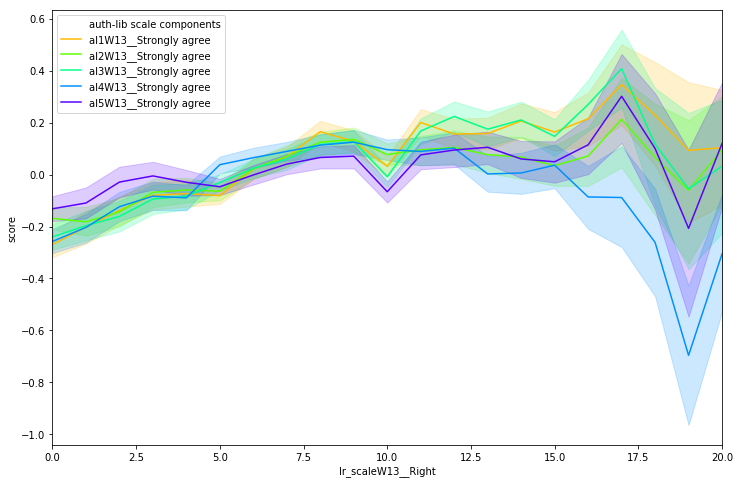

In [78]:
al_values = [x for x in BES_reduced_with_na.columns if re.match("((al)\d)\w*W13",x)] # |redistSelf
x_scale = 'lr_scaleW13__Right'

al_vals_by_lr = BES_reduced_with_na[ al_values + [x_scale] ].copy().set_index(x_scale).dropna()
# standardise
al_vals_by_lr = (al_vals_by_lr-al_vals_by_lr.mean()) / al_vals_by_lr.std()
al_vals_by_lr = al_vals_by_lr.stack().reset_index()
al_vals_by_lr.columns = [x_scale, "auth-lib scale components", "score"]


plt.figure(figsize=(12,8))
sns.lineplot(y="score",
             x=x_scale,
             hue = "auth-lib scale components",
             data = al_vals_by_lr,
             palette = 'gist_rainbow')
plt.xlim(0,20);
plt.savefig(redistribution_subfolder + "al_vars_by_lr_scale_standardised" + ".png", bbox_inches='tight')

In [ ]:
# redo with generalised uniform al_scale/lr_scale

In [94]:
granularity = 21
lr_uniform = pd.qcut( BES_genImmSentiment['raw_gen_lr_vals'], q=granularity, labels=range(0,granularity))
al_uniform = pd.qcut( BES_genImmSentiment['raw_gen_al_vals'], q=granularity, labels=range(0,granularity))

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


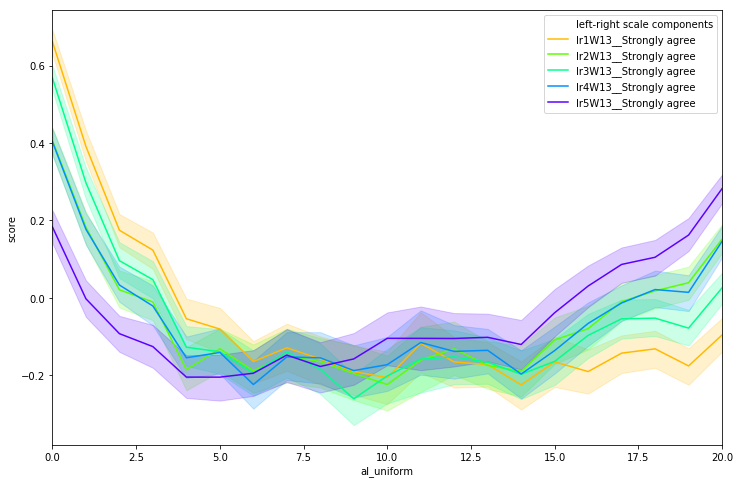

In [127]:
lr_values = [x for x in BES_reduced_with_na.columns if re.match("((lr)\d)\w*W13",x)] # |redistSelf

lr_vals_by_al = BES_reduced_with_na[ lr_values ].copy()
lr_vals_by_al["al_uniform"] = al_uniform

lr_vals_by_al = lr_vals_by_al.set_index("al_uniform").dropna()
# standardise
lr_vals_by_al = (lr_vals_by_al-lr_vals_by_al.mean()) / lr_vals_by_al.std()
lr_vals_by_al = lr_vals_by_al.stack().reset_index()
lr_vals_by_al.columns = ["al_uniform", "left-right scale components", "score"]


plt.figure(figsize=(12,8))
sns.lineplot(y="score",
             x="al_uniform",
             hue = "left-right scale components",
             data = lr_vals_by_al,
             palette = 'gist_rainbow')
plt.xlim(0,granularity-1);
plt.savefig(redistribution_subfolder + "lr_vars_by_al_scale_standardised_uniform" + ".png", bbox_inches='tight')

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


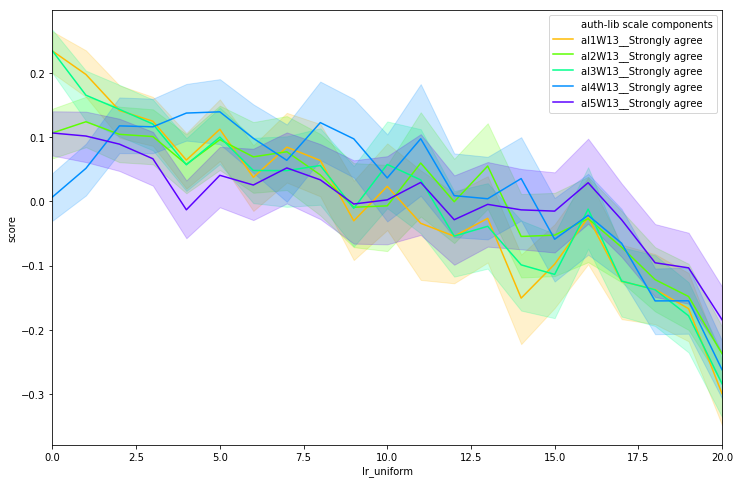

In [98]:
al_values = [x for x in BES_reduced_with_na.columns if re.match("((al)\d)\w*W13",x)] # |redistSelf
x_scale = 'lr_uniform'

al_vals_by_lr = BES_reduced_with_na[ al_values ].copy()
al_vals_by_lr[x_scale] = lr_uniform


al_vals_by_lr=al_vals_by_lr.set_index(x_scale).dropna()
# standardise
al_vals_by_lr = (al_vals_by_lr-al_vals_by_lr.mean()) / al_vals_by_lr.std()
al_vals_by_lr = al_vals_by_lr.stack().reset_index()
al_vals_by_lr.columns = [x_scale, "auth-lib scale components", "score"]


plt.figure(figsize=(12,8))
sns.lineplot(y="score",
             x=x_scale,
             hue = "auth-lib scale components",
             data = al_vals_by_lr,
             palette = 'gist_rainbow')
plt.xlim(0,granularity-1);
plt.savefig(redistribution_subfolder + "al_vars_by_lr_scale_standardised_uniform" + ".png", bbox_inches='tight')

In [79]:
[x for x in BES_reduced_with_na.columns if "likeCorbyn" in x]

['likeCorbynW7__Strongly like',
 'likeCorbynW8__Strongly like',
 'likeCorbynW9__Strongly like',
 'likeCorbynW10__Strongly like',
 'likeCorbynW11__Strongly like',
 'likeCorbynW12__Strongly like',
 'likeCorbynW13__Strongly like']

In [80]:
al_lr_valuesW13 = [x for x in BES_reduced_with_na.columns if re.match("((al|lr)\d|redistSelf)\w*W13",x)]

In [81]:
BES_reduced_with_na[al_lr_valuesW13].corrwith(BES_reduced_with_na['likeCorbynW13__Strongly like'])

redistSelfW13__Government should be less concerned about equal incomes   -0.474530
lr1W13__Strongly agree                                                    0.513140
lr2W13__Strongly agree                                                    0.340690
lr3W13__Strongly agree                                                    0.449882
lr4W13__Strongly agree                                                    0.385982
lr5W13__Strongly agree                                                    0.235041
al1W13__Strongly agree                                                   -0.406568
al2W13__Strongly agree                                                   -0.350803
al3W13__Strongly agree                                                   -0.314817
al4W13__Strongly agree                                                   -0.192230
al5W13__Strongly agree                                                   -0.295960
dtype: float64

In [82]:
### create a redistribution factor

In [15]:
redist_vars = [x for x in BES_reduced_with_na.columns if re.match("((lr1)|redistSelf)\w*",x)]

In [20]:
BES_immig = BES_reduced[redist_vars]

Wall time: 4.12 s


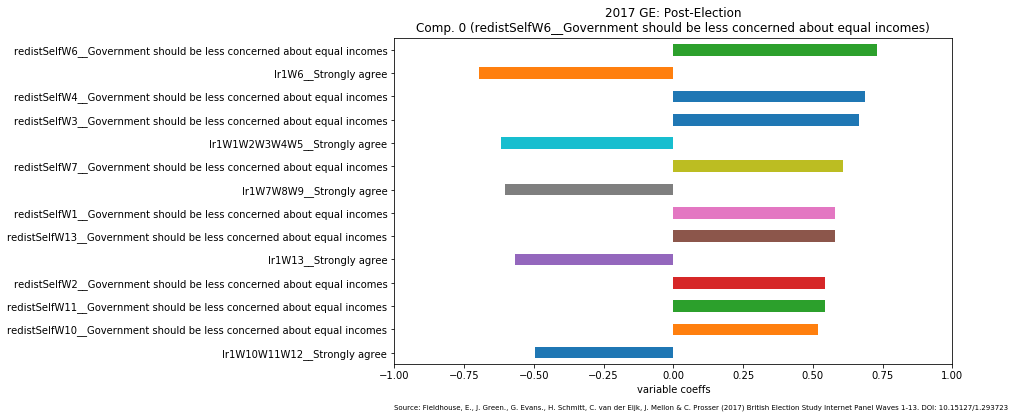

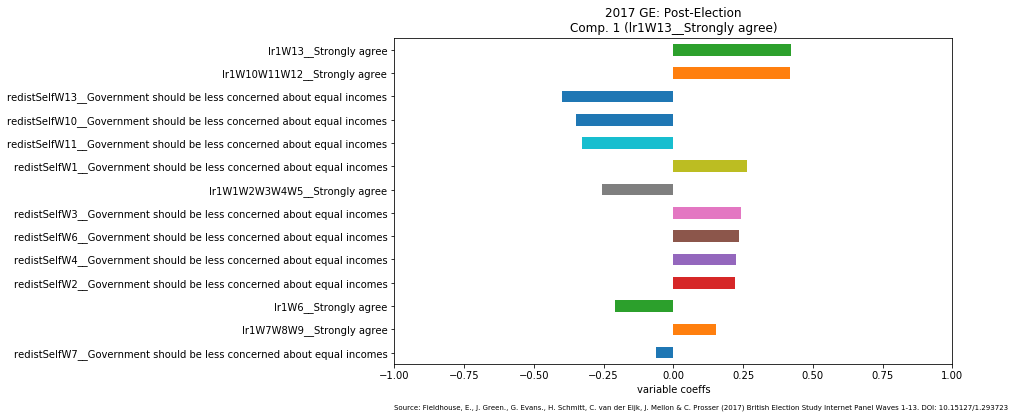

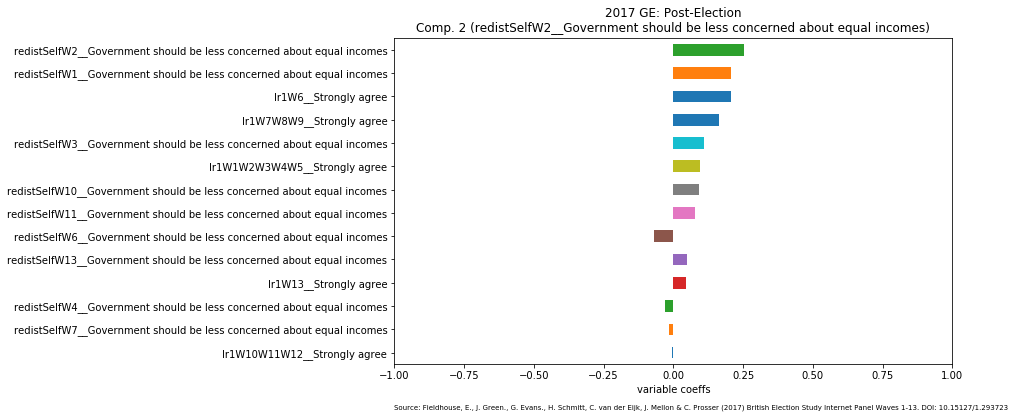

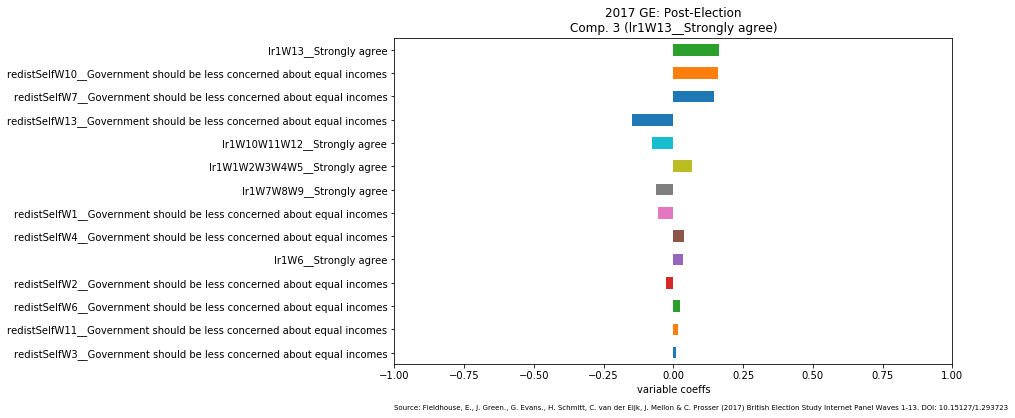

In [25]:
%%time
Treatment = "pan-dataset-values" + "_redistribution"

output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )
    
    

clean_feature_set_std = StandardScaler().fit_transform(BES_immig.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_immig.columns,
                             index   = BES_immig.index      )

n_components = BES_std.shape[1]
# n_components = 2

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
# decomp = SparsePCA(n_components = n_components, alpha = 32)
decomp_method = str(decomp).split("(")[0] 

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_std.index)

load_suff = "SparsePCA"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 
    
# display_pca_data(n_components, decomp, BES_std)

(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_std.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

In [26]:
comp_dict[0].sort_values(by='comp_absmag', ascending=False).iloc[0:50]

components_  comp_absmag
redistSelfW6__Government should be less concern...     0.730115     0.730115
lr1W6__Strongly agree                                 -0.696877     0.696877
redistSelfW4__Government should be less concern...     0.688223     0.688223
redistSelfW3__Government should be less concern...     0.663775     0.663775
lr1W1W2W3W4W5__Strongly agree                         -0.617651     0.617651
redistSelfW7__Government should be less concern...     0.608289     0.608289
lr1W7W8W9__Strongly agree                             -0.602079     0.602079
redistSelfW1__Government should be less concern...     0.580070     0.580070
redistSelfW13__Government should be less concer...     0.579088     0.579088
lr1W13__Strongly agree                                -0.567386     0.567386
redistSelfW2__Government should be less concern...     0.543570     0.543570
redistSelfW11__Government should be less concer...     0.542373     0.542373
redistSelfW10__Government should be less concer...     0.518961     0.518961
lr1W10W11W12__Strongly agree                          -0.495056     0.495056

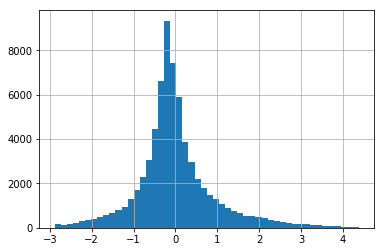

In [33]:
redist = BES_decomp[0]
redist.hist(bins=50);

In [35]:
redist_corr = BES_reduced_with_na.corrwith( redist )

In [37]:
redist_corr.sort_values()

lr1W6__Strongly agree                                                    -0.803647
lr1W13__Strongly agree                                                   -0.739264
lr1W7W8W9__Strongly agree                                                -0.694418
lr1W1W2W3W4W5__Strongly agree                                            -0.691207
lr1W10W11W12__Strongly agree                                             -0.681093
lr3W6__Strongly agree                                                    -0.675056
cutsTooFarNationalW6__Gone much too far                                  -0.615563
lr3W13__Strongly agree                                                   -0.613885
lr4W6__Strongly agree                                                    -0.605100
preferConMajorityW5__Ranked fifth                                        -0.601283
preferConMajorityW4__Ranked fifth                                        -0.595093
cutsTooFarNationalW4__Gone much too far                                  -0.565345
cuts

In [38]:
redist_corr2 = BES_reduced_with_na.corrwith( BES_decomp[1] )


In [39]:
redist_corr2.sort_values()

redistSelfW13__Government should be less concerned about equal incomes   -0.630185
redistSelfW10__Government should be less concerned about equal incomes   -0.589187
redistSelfW11__Government should be less concerned about equal incomes   -0.558766
lr_scaleW13__Right                                                       -0.528070
lr_scaleW10W11W12__Right                                                 -0.514187
lr1W1W2W3W4W5__Strongly agree                                            -0.404300
ptvConW13__Very likely                                                   -0.392760
likeConW13__Strongly like                                                -0.386608
leftRightW13__Right                                                      -0.385958
leftRightW10__Right                                                      -0.371808
ptvConW10__Very likely                                                   -0.368060
likeConW10__Strongly like                                                -0.362476
left

In [41]:
class_war_vars = [x for x in BES_reduced_with_na.columns if re.match("(lr5)\w*",x)]
class_war_vars

['lr5W6__Strongly agree',
 'lr5W13__Strongly agree',
 'lr5W1W2W3W4W5__Strongly agree',
 'lr5W7W8W9__Strongly agree',
 'lr5W10W11W12__Strongly agree']

In [50]:
lr5_gen = BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("(lr5)\w*",x)]].mean(axis=1)
lr5_gen_corr2 = BES_reduced_with_na.corrwith( lr5_gen )
lr5_gen_corr2.loc[[x for x in lr5_gen_corr2.index if not re.match("lr(\d|_)|redistSelf",x)]].sort_values()

zeroHourContractW6__Should definitely be legal   -0.408236
approveUKGovtW2__Strongly approve                -0.402163
approveUKGovtW4__Strongly approve                -0.399976
approveUKGovtW3__Strongly approve                -0.395034
conGovTrustW5__ Would do a good job              -0.392603
likeCameronW6__Strongly like                     -0.390887
approveUKGovtW1__Strongly approve                -0.389221
handleMIIConW5__Very well                        -0.388488
likeConW8__Strongly like                         -0.386477
likeConW7__Strongly like                         -0.385986
likeCameronW4__Strongly like                     -0.384022
approveUKGovtW7__Strongly approve                -0.381834
ptvConW7__Very likely                            -0.379586
likeCameronW5__Strongly like                     -0.379516
likeCameronW3__Strongly like                     -0.379449
conLookAfterWCW10__Very closely                  -0.376259
changeEconomyW3__Getting a lot better            -0.3741

In [51]:
lr5_gen = BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("(lr1)\w*",x)]].mean(axis=1)
lr5_gen_corr2 = BES_reduced_with_na.corrwith( lr5_gen )
lr5_gen_corr2.loc[[x for x in lr5_gen_corr2.index if not re.match("lr(\d|_)|redistSelf",x)]].sort_values()

leftRightW6__Right                          -0.591557
conGovTrustW5__ Would do a good job         -0.591004
leftRightW5__Right                          -0.583865
ptvConW7__Very likely                       -0.573144
likeCameronW6__Strongly like                -0.572201
ptvConW9__Very likely                       -0.571272
likeConW7__Strongly like                    -0.570605
leftRightW3__Right                          -0.570129
ptvConW13__Very likely                      -0.568532
leftRightW7__Right                          -0.566870
leftRightW13__Right                         -0.566696
likeConW8__Strongly like                    -0.566665
likeConW9__Strongly like                    -0.561837
leftRightW11__Right                         -0.556845
likeConW13__Strongly like                   -0.556072
leftRightW12__Right                         -0.555876
leftRightW4__Right                          -0.555600
likeCameronW5__Strongly like                -0.555017
handleMIIConW5__Very well   

In [56]:
lr5_gen = BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("(leftRight)\w*",x)]].mean(axis=1)
lr5_gen_corr2 = BES_reduced_with_na.corrwith( lr5_gen )
# lr5_gen_corr2.loc[[x for x in lr5_gen_corr2.index if not re.match("lr(\d|_)|redistSelf",x)]].sort_values()
# lr5_gen_corr2.sort_values()

lr5_gen_corr2.loc[al_lr_valuesW13].sort_values()


# no big differences over time!

lr1W13__Strongly agree                                                   -0.553592
lr3W13__Strongly agree                                                   -0.489992
lr4W13__Strongly agree                                                   -0.424980
lr2W13__Strongly agree                                                   -0.386177
lr5W13__Strongly agree                                                   -0.270792
al4W13__Strongly agree                                                    0.288484
al5W13__Strongly agree                                                    0.376901
al3W13__Strongly agree                                                    0.404911
al2W13__Strongly agree                                                    0.440050
al1W13__Strongly agree                                                    0.470999
redistSelfW13__Government should be less concerned about equal incomes    0.543395
dtype: float64

In [ ]:
### Englishness and Britishness twitter comment

In [66]:
England_only = BES_Panel["country"]=="England"

englishness_gen = BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("(english)\w*",x)]][England_only].mean(axis=1)
englishness_gen_corr2 = BES_reduced_with_na.corrwith( englishness_gen )

englishness_gen_corr2.sort_values().dropna()

immigSelfW9__Allow many more                     -0.434475
immigSelfW7__Allow many more                     -0.429170
immigSelfW8__Allow many more                     -0.425942
immigSelfW10__Allow many more                    -0.421895
immigSelfW11__Allow many more                    -0.419137
immigCulturalW3__Enriches cultural life          -0.413548
immigEconW3__Good for economy                    -0.413169
immigCulturalW8__Enriches cultural life          -0.402939
immigEconW8__Good for economy                    -0.399785
immigCulturalW2__Enriches cultural life          -0.398026
immigCulturalW7__Enriches cultural life          -0.397973
immigCulturalW13__Enriches cultural life         -0.396686
immigEconW7__Good for economy                    -0.396390
immigEconW2__Good for economy                    -0.393618
likeSturgeonW11__Strongly like                   -0.390093
immigEconW4__Good for economy                    -0.390050
immigCulturalW10__Enriches cultural life         -0.3885

In [65]:
englishness_gen_corr2.loc[al_lr_valuesW13].sort_values()

lr1W13__Strongly agree                                                   -0.175810
lr3W13__Strongly agree                                                   -0.134382
lr2W13__Strongly agree                                                   -0.109052
lr4W13__Strongly agree                                                   -0.098864
lr5W13__Strongly agree                                                   -0.036209
redistSelfW13__Government should be less concerned about equal incomes    0.175493
al4W13__Strongly agree                                                    0.268635
al5W13__Strongly agree                                                    0.317463
al3W13__Strongly agree                                                    0.322407
al2W13__Strongly agree                                                    0.328420
al1W13__Strongly agree                                                    0.369595
dtype: float64

In [68]:
England_only = BES_Panel["country"]=="England"

britishness_gen = BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match("(british)\w*",x)]][England_only].mean(axis=1)
britishness_gen_corr2 = BES_reduced_with_na.corrwith( britishness_gen )

britishness_gen_corr2.sort_values().dropna()

profile_ethnicity_Any other white background                                                                       -0.331691
profile_ethnicityW12_Any other white background                                                                    -0.318358
passportOtherW9_Yes                                                                                                -0.275636
bestPMW12_Jeremy Corbyn                                                                                            -0.263031
immigSelfW10__Allow many more                                                                                      -0.245529
immigSelfW11__Allow many more                                                                                      -0.234458
likeSturgeonW11__Strongly like                                                                                     -0.231335
likeSNPW12__Strongly like                                                                                          -0.227998


In [69]:
britishness_gen_corr2.loc[al_lr_valuesW13].sort_values()

lr3W13__Strongly agree                                                   -0.123098
lr1W13__Strongly agree                                                   -0.120541
lr4W13__Strongly agree                                                   -0.118070
lr2W13__Strongly agree                                                   -0.115637
lr5W13__Strongly agree                                                   -0.081999
redistSelfW13__Government should be less concerned about equal incomes    0.124570
al2W13__Strongly agree                                                    0.157575
al5W13__Strongly agree                                                    0.182371
al4W13__Strongly agree                                                    0.212372
al1W13__Strongly agree                                                    0.217864
al3W13__Strongly agree                                                    0.222256
dtype: float64

In [ ]:
#############   Let's try to decompose lr_scale by al_scale

In [22]:
granularity = 50
lr_uniform = pd.qcut( BES_genImmSentiment['raw_gen_lr_vals'], q=granularity, labels=range(0,granularity))
al_uniform = pd.qcut( BES_genImmSentiment['raw_gen_al_vals'], q=granularity, labels=range(0,granularity)) #, labels=ra

In [24]:
lr_values = [x for x in BES_reduced_with_na.columns if re.match("((lr)\d|redistSelf)\w*",x)]
corrs = BES_reduced_with_na[lr_values].multiply(al_uniform,axis=0).corrwith(lr_uniform)
corrs.sort_values()

redistSelfW6__Government should be less concerned about equal incomes    -0.509738
redistSelfW3__Government should be less concerned about equal incomes    -0.508394
redistSelfW1__Government should be less concerned about equal incomes    -0.500689
redistSelfW4__Government should be less concerned about equal incomes    -0.492273
redistSelfW11__Government should be less concerned about equal incomes   -0.476717
redistSelfW13__Government should be less concerned about equal incomes   -0.468874
redistSelfW10__Government should be less concerned about equal incomes   -0.461618
redistSelfW7__Government should be less concerned about equal incomes    -0.453006
redistSelfW2__Government should be less concerned about equal incomes    -0.439460
lr5W7W8W9__Strongly agree                                                 0.149134
lr2W1W2W3W4W5__Strongly agree                                             0.150799
lr2W7W8W9__Strongly agree                                                 0.152826
lr5W

In [23]:
lr_values = [x for x in BES_reduced_with_na.columns if re.match("((lr)\d|redistSelf)\w*",x)]
corrs = BES_reduced_with_na[lr_values].multiply(BES_genImmSentiment['raw_gen_al_vals'],axis=0).corrwith(BES_genImmSentiment['raw_gen_lr_vals'])
corrs.sort_values()

lr2W6__Strongly agree                                                    -0.155334
lr5W6__Strongly agree                                                    -0.151543
lr2W1W2W3W4W5__Strongly agree                                            -0.149367
lr2W13__Strongly agree                                                   -0.147573
lr2W7W8W9__Strongly agree                                                -0.146684
lr5W13__Strongly agree                                                   -0.145442
lr3W6__Strongly agree                                                    -0.143803
lr5W7W8W9__Strongly agree                                                -0.142451
lr5W1W2W3W4W5__Strongly agree                                            -0.142192
lr4W6__Strongly agree                                                    -0.142065
lr3W1W2W3W4W5__Strongly agree                                            -0.138848
lr3W7W8W9__Strongly agree                                                -0.137476
lr1W

In [25]:
# lr_values = [x for x in BES_reduced_with_na.columns if re.match("((lr)\d|redistSelf)\w*",x)]
corrs = BES_reduced_with_na.multiply(al_uniform,axis=0).corrwith(lr_uniform)
corrs.sort_values()

lr_scaleW6__Right                                                        -0.612627
lr_scaleW1W2W3W4W5__Right                                                -0.602972
lr_scaleW7W8W9__Right                                                    -0.596551
lr_scaleW10W11W12__Right                                                 -0.583136
lr_scaleW13__Right                                                       -0.581426
redistSelfW6__Government should be less concerned about equal incomes    -0.509738
redistSelfW3__Government should be less concerned about equal incomes    -0.508394
redistSelfW1__Government should be less concerned about equal incomes    -0.500689
redistSelfW4__Government should be less concerned about equal incomes    -0.492273
redistSelfW11__Government should be less concerned about equal incomes   -0.476717
redistSelfW13__Government should be less concerned about equal incomes   -0.468874
ptvConW7__Very likely                                                    -0.467081
redi

In [29]:
corrs.sort_values().head(100)

lr_scaleW6__Right                                                                       -0.612627
lr_scaleW1W2W3W4W5__Right                                                               -0.602972
lr_scaleW7W8W9__Right                                                                   -0.596551
lr_scaleW10W11W12__Right                                                                -0.583136
lr_scaleW13__Right                                                                      -0.581426
redistSelfW6__Government should be less concerned about equal incomes                   -0.509738
redistSelfW3__Government should be less concerned about equal incomes                   -0.508394
redistSelfW1__Government should be less concerned about equal incomes                   -0.500689
redistSelfW4__Government should be less concerned about equal incomes                   -0.492273
redistSelfW11__Government should be less concerned about equal incomes                  -0.476717
redistSelfW13__Gover

In [33]:
corrs.sort_values().tail(50)

preferConCoalitionW5__Ranked fifth           0.225306
changeEconomyLabW10__Getting a lot better    0.225320
labHopeW6_Yes                                0.225940
ptvLabW10__Very likely                       0.226542
bestOnMIIW1_Labour                           0.226910
lr4W1W2W3W4W5__Strongly agree                0.228685
responsibleDebtConservativesW3_Yes           0.232281
worstLeaderCampaignW5_David Cameron          0.232563
bestOnMIIW11_Labour                          0.235201
bestOnMIIW4_Labour                           0.236023
ptvLabW7__Very likely                        0.238690
responsibleDebtConservativesW1_Yes           0.241521
bestOnMIIW5_Labour                           0.243632
lr3W6__Strongly agree                        0.243899
conFearW6_Yes                                0.243922
lr4W13__Strongly agree                       0.244770
likeCorbynW13__Strongly like                 0.246957
bestOnMIIW6_Labour                           0.248609
ptvLabW11__Very likely      

In [12]:
corrs = BES_reduced_with_na.multiply(BES_genImmSentiment['raw_gen_al_vals'],axis=0).corrwith(BES_genImmSentiment['raw_gen_lr_vals'])
corrs.sort_values()

bestPMW12_Jeremy Corbyn                                                 -0.276403
likeLucasW12__Strongly like                                             -0.273888
handleMIIGrnW5__Very well                                               -0.259721
lrUKIPW12__Right                                                        -0.254023
redistConW11__Government should be less concerned about equal incomes   -0.252849
lrUKIPW5__Right                                                         -0.251685
lrUKIPW4__Right                                                         -0.250781
lrUKIPW7__Right                                                         -0.249850
lrUKIPW6__Right                                                         -0.248786
lrUKIPW2__Right                                                         -0.246468
redistConW6__Government should be less concerned about equal incomes    -0.245193
lrUKIPW11__Right                                                        -0.244816
redistConW13__Go

In [ ]:
#############################################
#############################################
# Don't Knowishness




In [39]:
%%time
null_perc = BES_reduced_with_na.isnull().mean(axis=1)

Wall time: 2.7 s


In [6]:
%%time
Weasel_answers = ["Don't know",
                  "Prefer not to say", "Prefer not to answer", "Refused", "Unknown",
                  "Neither", "Other", "I would/will not vote", "Will not vote",
                  "I would not vote", "It depends", "Other",
                  "Don't follow politics on twitter",
                  "Yes, other", "Haven't thought about it",
                  "There wasn't a local election in my area", "No, haven't received it",
                  "I don't know what was negotiated", "I never received a response",
                  "There are not local elections in my area", "Can't remember",
                  "Varies too much to say", "Will not state a choice",
                  "All leaders equally good", "They are not eligible to vote",
                  "There are not local elections in my area", "Both/neither",
                  "Did not vote","Can't remember",
                  "Not sure"]

# BES codes for NaN/other/misc/none of the above
Weasel_number_answers = [ "9999.0", "997.0", "222.0", "99.0", "0.0", "9999", "98.0" ]


dks = BES_Panel.applymap(lambda x: x in (Weasel_answers + Weasel_number_answers) if isinstance(x,str) else False)
dks_perc = dks.mean(axis=1)

Wall time: 3min 22s


In [7]:
dks_corr = BES_reduced_with_na.corrwith( dks_perc )
dks_corr.sort_values()

polAttentionW7__Pay a great deal of attention    -0.498208
polAttentionW8__Pay a great deal of attention    -0.488921
polAttentionW6__Pay a great deal of attention    -0.479874
polAttentionW4__Pay a great deal of attention    -0.478999
polAttentionW3__Pay a great deal of attention    -0.470238
polAttentionW2__Pay a great deal of attention    -0.452905
electionInterestW4__Very interested              -0.438320
electionInterestW6__Very interested              -0.434299
electionInterestW5__Very interested              -0.433347
polAttentionW11__Pay a great deal of attention   -0.426737
polAttentionW1__Pay a great deal of attention    -0.425844
efficacyUnderstandW6__Strongly agree             -0.415390
polAttentionW10__Pay a great deal of attention   -0.412402
efficacyUnderstandW4__Strongly agree             -0.412153
efficacyUnderstandW8__Strongly agree             -0.409984
polAttentionW13__Pay a great deal of attention   -0.405261
efficacyUnderstandW7__Strongly agree             -0.4016

In [10]:
from scipy import stats
# data = np.array([[0, 1, -1], [0, -1, 1], [0, 1, -1]])
# print 'np.corrcoef:', np.corrcoef(data)
# cor, pval = stats.spearmanr(data.T)
# print 'stats.spearmanr - cor:\n', cor
# print 'stats.spearmanr - pval\n', pval

In [33]:
BES_reduced_with_na["dks_perc"] = dks_perc

In [34]:
%%time
rho, pval = stats.spearmanr(BES_reduced_with_na.values, nan_policy='omit')

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:3323: RuntimeWarning: invalid value encountered in sqrt
  t = rs * np.sqrt(((n-2)/((rs+1.0)*(1.0-rs))).clip(0))


Wall time: 44.2 s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000299EB940>]],
      dtype=object)

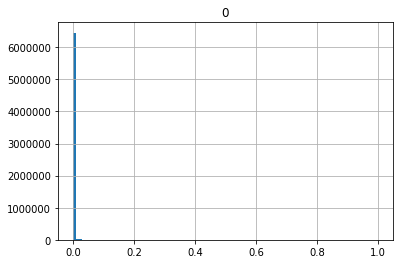

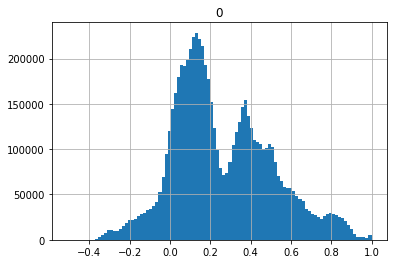

In [41]:
pd.DataFrame(pval.ravel()).hist(bins=100)
pd.DataFrame(rho.ravel()).hist(bins=100)

In [50]:
rho.shape[0]
pd.Series(rho[rho.shape[0]-1],index = BES_reduced_with_na.columns).sort_values()

polAttentionW7__Pay a great deal of attention                          -0.345456
polAttentionW4__Pay a great deal of attention                          -0.337626
polAttentionW6__Pay a great deal of attention                          -0.312961
polAttentionW8__Pay a great deal of attention                          -0.312009
riskTakingW7__Very willing to take risks                               -0.305408
euRefInterestW7__Very interested                                       -0.297018
efficacyUnderstandW7__Strongly agree                                   -0.292134
efficacyUnderstandW4__Strongly agree                                   -0.288906
electionInterestW6__Very interested                                    -0.283829
electionInterestW4__Very interested                                    -0.283639
efficacyUnderstandW8__Strongly agree                                   -0.282751
polAttentionW10__Pay a great deal of attention                         -0.280218
euRefInterestW8__Very intere

polAttentionW7__Pay a great deal of attention                          -0.345456
polAttentionW4__Pay a great deal of attention                          -0.337626
polAttentionW6__Pay a great deal of attention                          -0.312961
polAttentionW8__Pay a great deal of attention                          -0.312009
riskTakingW7__Very willing to take risks                               -0.305408
euRefInterestW7__Very interested                                       -0.297018
efficacyUnderstandW7__Strongly agree                                   -0.292134
efficacyUnderstandW4__Strongly agree                                   -0.288906
electionInterestW6__Very interested                                    -0.283829
electionInterestW4__Very interested                                    -0.283639
efficacyUnderstandW8__Strongly agree                                   -0.282751
polAttentionW10__Pay a great deal of attention                         -0.280218
euRefInterestW8__Very intere

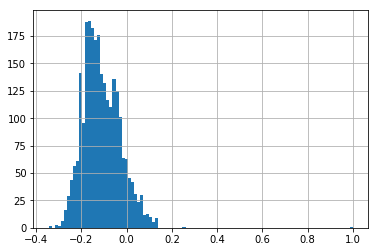

In [64]:
corr_series = pd.Series(rho[rho.shape[0]-1],index = BES_reduced_with_na.columns).sort_values()
corr_series.hist(bins=100);

thresh = 0.025
# corr_series.quantile(thresh)
corr_series_highlights = corr_series[ np.logical_or(corr_series<corr_series.quantile(thresh),
                           corr_series>corr_series.quantile(1-thresh))]
corr_series_highlights

In [70]:
def get_stub(x):
    if "__" in x:
        x = x.split("__")[0]
    if "_" in x:
        x = x.split("_")[0]
    if re.match("(.+)(W\d)+",x):
        x = re.match("(.+?)(W\d)+",x).groups(0)[0]
    return x

np.unique([get_stub(x) for x in corr_series_highlights.index])

array(['anyUni', 'bestOnMII', 'discussPolDays', 'dks', 'dutyToVote2',
       'efficacyEU', 'efficacyEnjoyVote', 'efficacyUnderstand',
       'electionInterest', 'engFairShare', 'ethno3', 'euRefInterest',
       'euRefTurnout', 'fbUse', 'gender', 'infoSourceInternet',
       'infoSourcePaper', 'infoSourcePeople', 'infoSourceRadio',
       'infoSourceTV', 'leftRight', 'lrgreens', 'participation',
       'partyIdStrength', 'partyMember', 'polAttention', 'polKnowAssad',
       'polKnowHollande', 'polKnowKerry', 'polKnowNetanyahu', 'profile',
       'redistCon', 'redistLD', 'redistLab', 'registered',
       'responsibleCrimeConservatives', 'responsibleCrimeLabour',
       'responsibleCrimeLibDems', 'responsibleCrimeNone',
       'responsibleEducationCon', 'responsibleEducationLD',
       'responsibleEducationLab', 'responsibleEducationNone',
       'responsibleImmigConservatives', 'responsibleImmigLabour',
       'responsibleImmigLibDems', 'responsibleImmigNone',
       'responsibleNHSConse

In [29]:
%%time
from scipy.stats import spearmanr, pearsonr

# SERIES OF TUPLES (<scipy.stats.stats.SpearmanrResult> class)
spr_all_result = BES_reduced_with_na.apply(lambda col: spearmanr(col, dks_perc), axis=0)

# SERIES OF FLOATS
# spr_corr = a.apply(lambda col: spearmanr(col, b.ix[:,0])[0], axis=0)
# spr_pvalues = a.apply(lambda col: spearmanr(col, b.ix[:,0])[1], axis=0)

KeyboardInterrupt: 

In [19]:
dks_perc.values.reshape(-1, 1).shape

(68625, 1)

In [53]:
dks_corr.sort_values().tail(100)

strongLeaderW10__Strongly agree                                  0.166218
partydiffconlabW11__There is not much difference between them    0.168993
strongLeaderW11__Strongly agree                                  0.170890
efficacyTooMuchEffortW9__Strongly agree                          0.171390
ldNoneW4_Yes                                                     0.171620
efficacyTooMuchEffortW4__Strongly agree                          0.172191
efficacyNoMatterW9__Strongly agree                               0.173549
immigContributeTakeW8__Get more than they pay                    0.173621
ukipNoneW6_Yes                                                   0.176788
efficacyNoMatterW4__Strongly agree                               0.178073
tryReduceInequalityNoneW4_Yes                                    0.179303
ldSupportW8__Mainly leave                                        0.179445
gender_Female                                                    0.179598
decidedVoteW5_No, not decided yet     

In [57]:
al_lr_values = [x for x in BES_reduced.columns if re.match("(al|lr)\d|redistSelf",x)]

BES_reduced_with_na[al_lr_values].corrwith( dks_perc ).sort_values()

redistSelfW6__Government should be less concerned about equal incomes    -0.051906
redistSelfW2__Government should be less concerned about equal incomes    -0.050770
redistSelfW13__Government should be less concerned about equal incomes   -0.047124
redistSelfW11__Government should be less concerned about equal incomes   -0.046449
redistSelfW1__Government should be less concerned about equal incomes    -0.044125
redistSelfW3__Government should be less concerned about equal incomes    -0.043998
lr2W1W2W3W4W5__Strongly agree                                            -0.043673
redistSelfW10__Government should be less concerned about equal incomes   -0.043578
redistSelfW7__Government should be less concerned about equal incomes    -0.042483
lr2W7W8W9__Strongly agree                                                -0.038281
lr2W10W11W12__Strongly agree                                             -0.037497
redistSelfW4__Government should be less concerned about equal incomes    -0.037159
lr2W

In [41]:
dk_corr = BES_reduced_with_na.corrwith( null_perc )

In [42]:
dk_corr.sort_values()

Age                                                 -0.357477
ageGroup__66+                                       -0.357155
polAttentionW11__Pay a great deal of attention      -0.280932
profile_work_statW7_Retired                         -0.277980
polAttentionW10__Pay a great deal of attention      -0.271175
polAttentionW13__Pay a great deal of attention      -0.256208
polAttentionW4__Pay a great deal of attention       -0.251427
allSourceIncome_2W6_Yes                             -0.241802
allSourceIncome_2W11_Yes                            -0.236906
efficacyUnderstandW11__Strongly agree               -0.232964
workingStatusW6_W12_Retired                         -0.230283
polAttentionW3__Pay a great deal of attention       -0.225862
profile_work_statW12_Retired                        -0.222858
efficacyUnderstandW10__Strongly agree               -0.222277
turnoutUKGeneralW4__Very likely that I will vote    -0.214236
allSourceIncome_3W6_Yes                             -0.213125
allSourc

In [43]:
gc.collect()

160

In [100]:
BES_genImmSentiment = pd.read_csv(BES_small_data_files + "pan_dataset_values"+".csv")

In [102]:
immig_sent_corr = BES_reduced_with_na.corrwith(BES_genImmSentiment["genImmigSentiment"])

In [106]:
immig_sent_corr.sort_values().head(80)

euPriorityBalanceW11__Control immigration              -0.794756
euPriorityBalanceW13__Control immigration              -0.791487
euPriorityBalanceW10__Control immigration              -0.776277
immigrantsWelfareStateW8__Strongly agree               -0.772673
euPriorityBalanceW12__Control immigration              -0.770661
immigrantsWelfareStateW11__Strongly agree              -0.767041
immigrantsWelfareStateW7__Strongly agree               -0.758758
happyEULeaveW11__Extremely happy                       -0.741846
immigrantsWelfareStateW10__Strongly agree              -0.738500
EUIntegrationSelfW11__Protect our independence         -0.727523
happyEULeaveW9__Extremely happy                        -0.722108
happyEULeaveW10__Extremely happy                       -0.720937
euUndermineIdentityW8__Strongly agree                  -0.714964
EUIntegrationSelfW13__Protect our independence         -0.714541
ukCoopMovementW8__Bad for Britain                      -0.706519
EUIntegrationSelfW10__Pro

In [110]:
immig_sent_corr.loc[[x for x in immig_sent_corr.index if "discrim" in x]]

discrimMenW10__A lot of discrimination against          -0.239773
discrimWomenW10__A lot of discrimination against         0.210332
discrimChristiansW10__A lot of discrimination against   -0.344536
discrimMuslimsW10__A lot of discrimination against       0.400207
discrimBMEW10__A lot of discrimination against           0.406796
discrimWhiteW10__A lot of discrimination against        -0.477286
dtype: float64

In [112]:
immig_sent_corr.loc[[x for x in immig_sent_corr.index if "Equality" in x]]

blackEqualityW1W2W3W4W5__Gone much too far    -0.424032
femaleEqualityW1W2W3W4W5__Gone much too far   -0.221218
gayEqualityW1W2W3W4W5__Gone much too far      -0.320905
blackEqualityW6_W12__Gone much too far        -0.509011
femaleEqualityW6_W12__Gone much too far       -0.286738
gayEqualityW6_W12__Gone much too far          -0.381223
dtype: float64

In [111]:
immig_sent_corr.sort_values().tail(80)

satDemEUW9__Very satisfied                               0.513935
likeSturgeonW12__Strongly like                           0.517746
socialIdentityGlobalRemainW7__A great deal in common     0.520487
likeSturgeonW13__Strongly like                           0.520561
immigrationLevelW6__Increased a lot                      0.521044
effectsEUUnemploymentW8__Much higher                     0.523198
normEUW7__Strongly agree                                 0.525144
socialIdentityGlobalRemainW8__A great deal in common     0.525284
effectsEUUnemploymentW11__Much higher                    0.526738
likeLucasW12__Strongly like                              0.527692
noneuMoreW8__Many more                                   0.529068
normEUW8__Strongly agree                                 0.530406
immigEconW1__Good for economy                            0.536099
euPreventWarW7__Strongly agree                           0.536496
euLeaveBigBusinessW7__Much more likely                   0.538067
likeSturge

In [ ]:
# twitter use by value space


In [132]:
[x for x in BES_reduced_with_na.columns if re.match("fbUse",x)]

['fbUseW5_Yes', 'fbUseW4_Yes', 'fbUseW6_Yes', 'fbUseW12_Yes']

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


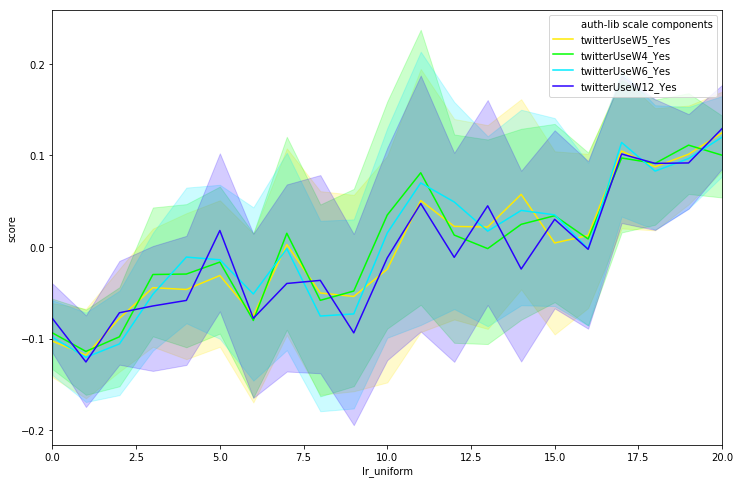

In [129]:
al_values = [x for x in BES_reduced_with_na.columns if re.match("((al)\d)\w*W13",x)] # |redistSelf
al_values =[x for x in BES_reduced_with_na.columns if re.match("twitter",x)]
x_scale = 'lr_uniform'

al_vals_by_lr = BES_reduced_with_na[ al_values ].copy()
al_vals_by_lr[x_scale] = lr_uniform


al_vals_by_lr=al_vals_by_lr.set_index(x_scale).dropna()
# standardise
al_vals_by_lr = (al_vals_by_lr-al_vals_by_lr.mean()) / al_vals_by_lr.std()
al_vals_by_lr = al_vals_by_lr.stack().reset_index()
al_vals_by_lr.columns = [x_scale, "auth-lib scale components", "score"]


plt.figure(figsize=(12,8))
sns.lineplot(y="score",
             x=x_scale,
             hue = "auth-lib scale components",
             data = al_vals_by_lr,
             palette = 'gist_rainbow')
plt.xlim(0,granularity-1);
plt.savefig(redistribution_subfolder + "twitter_by_lr_uniform" + ".png", bbox_inches='tight')

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


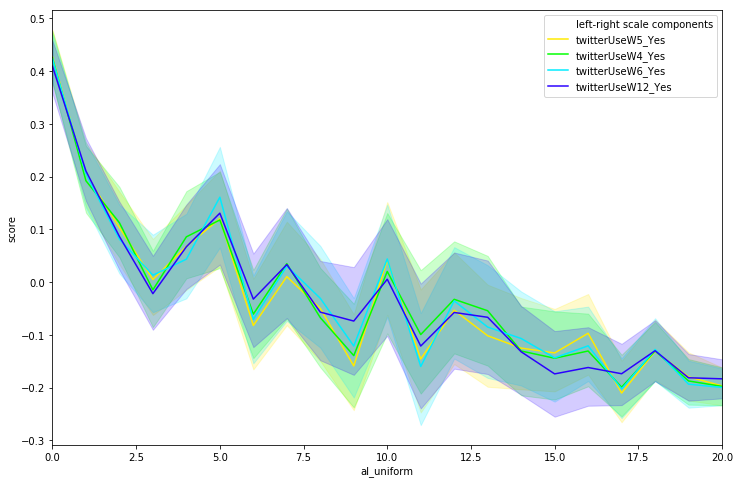

In [130]:
lr_values = [x for x in BES_reduced_with_na.columns if re.match("((lr)\d)\w*W13",x)] # |redistSelf
lr_values =[x for x in BES_reduced_with_na.columns if re.match("twitter",x)]

lr_vals_by_al = BES_reduced_with_na[ lr_values ].copy()
lr_vals_by_al["al_uniform"] = al_uniform

lr_vals_by_al = lr_vals_by_al.set_index("al_uniform").dropna()
# standardise
lr_vals_by_al = (lr_vals_by_al-lr_vals_by_al.mean()) / lr_vals_by_al.std()
lr_vals_by_al = lr_vals_by_al.stack().reset_index()
lr_vals_by_al.columns = ["al_uniform", "left-right scale components", "score"]


plt.figure(figsize=(12,8))
sns.lineplot(y="score",
             x="al_uniform",
             hue = "left-right scale components",
             data = lr_vals_by_al,
             palette = 'gist_rainbow')
plt.xlim(0,granularity-1);
plt.savefig(redistribution_subfolder + "twitter_by_al_uniform" + ".png", bbox_inches='tight')

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


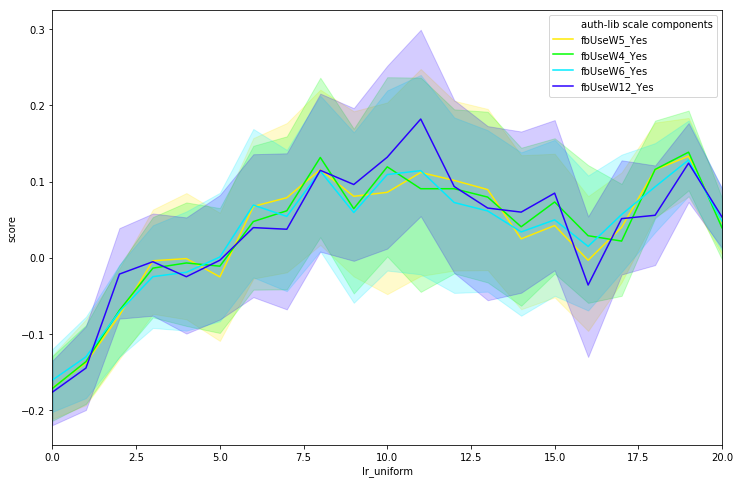

In [133]:
al_values = [x for x in BES_reduced_with_na.columns if re.match("((al)\d)\w*W13",x)] # |redistSelf
al_values =[x for x in BES_reduced_with_na.columns if re.match("fbUse",x)]
x_scale = 'lr_uniform'

al_vals_by_lr = BES_reduced_with_na[ al_values ].copy()
al_vals_by_lr[x_scale] = lr_uniform


al_vals_by_lr=al_vals_by_lr.set_index(x_scale).dropna()
# standardise
al_vals_by_lr = (al_vals_by_lr-al_vals_by_lr.mean()) / al_vals_by_lr.std()
al_vals_by_lr = al_vals_by_lr.stack().reset_index()
al_vals_by_lr.columns = [x_scale, "auth-lib scale components", "score"]


plt.figure(figsize=(12,8))
sns.lineplot(y="score",
             x=x_scale,
             hue = "auth-lib scale components",
             data = al_vals_by_lr,
             palette = 'gist_rainbow')
plt.xlim(0,granularity-1);
plt.savefig(redistribution_subfolder + "facebook_use_by_lr_uniform" + ".png", bbox_inches='tight')

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


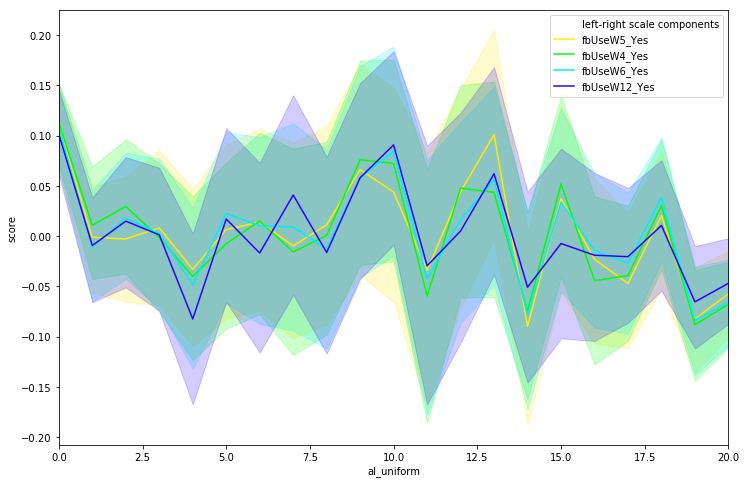

In [134]:
lr_values = [x for x in BES_reduced_with_na.columns if re.match("((lr)\d)\w*W13",x)] # |redistSelf
lr_values =[x for x in BES_reduced_with_na.columns if re.match("fbUse",x)]

lr_vals_by_al = BES_reduced_with_na[ lr_values ].copy()
lr_vals_by_al["al_uniform"] = al_uniform

lr_vals_by_al = lr_vals_by_al.set_index("al_uniform").dropna()
# standardise
lr_vals_by_al = (lr_vals_by_al-lr_vals_by_al.mean()) / lr_vals_by_al.std()
lr_vals_by_al = lr_vals_by_al.stack().reset_index()
lr_vals_by_al.columns = ["al_uniform", "left-right scale components", "score"]


plt.figure(figsize=(12,8))
sns.lineplot(y="score",
             x="al_uniform",
             hue = "left-right scale components",
             data = lr_vals_by_al,
             palette = 'gist_rainbow')
plt.xlim(0,granularity-1);
plt.savefig(redistribution_subfolder + "facebook_use_by_al_uniform" + ".png", bbox_inches='tight')

In [12]:
BES_Panel[[x for x in BES_Panel.columns if "negotiationSpecifics_2" in x]].apply(lambda x: x.cat.codes).replace(2, 0.5).replace(-1,np.nan).mean()

negotiationSpecifics_2W9     0.548758
negotiationSpecifics_2W10    0.604769
negotiationSpecifics_2W11    0.627281
negotiationSpecifics_2W13    0.632769
dtype: float64

In [22]:
FreeMovement = BES_Panel[[x for x in BES_Panel.columns if "ukCoopMovement" in x]].stack().reset_index().drop("level_0",axis=1)#
#.apply(lambda x: x.cat.codes).replace(2, 0.5).replace(-1,np.nan).mean()

FreeMovement

level_1                                 0
0       ukCoopMovementW7                   Bad for Britain
1       ukCoopMovementW8                   Bad for Britain
2      ukCoopMovementW10                   Bad for Britain
3       ukCoopMovementW7                   Bad for Britain
4       ukCoopMovementW8                   Bad for Britain
5      ukCoopMovementW10  Neither good nor bad for Britain
6       ukCoopMovementW7  Neither good nor bad for Britain
7      ukCoopMovementW10  Neither good nor bad for Britain
8       ukCoopMovementW7                   Bad for Britain
9       ukCoopMovementW7                   Bad for Britain
10      ukCoopMovementW8                   Bad for Britain
11     ukCoopMovementW10                   Bad for Britain
12      ukCoopMovementW7                   Bad for Britain
13     ukCoopMovementW10                   Bad for Britain
14      ukCoopMovementW7                  Good for Britain
15      ukCoopMovementW8                  Good for Britain
16     ukCoopMovementW10  Neither good nor bad for Britain
17      ukCoopMovementW7                  Good for Britain
18      ukCoopMovementW7                   Bad for Britain
19      ukCoopMovementW8                   Bad for Britain
20     ukCoopMovementW10  Neither good nor bad for Britain
21     ukCoopMovementW10                   Bad for Britain
22      ukCoopMovementW7                  Good for Britain
23      ukCoopMovementW8  Neither good nor bad for Britain
24     ukCoopMovementW10                  Good for Britain
25      ukCoopMovementW7                   Bad for Britain
26      ukCoopMovementW8                   Bad for Britain
27     ukCoopMovementW10                   Bad for Britain
28      ukCoopMovementW8                  Good for Britain
29     ukCoopMovementW10                  Good for Britain
...                  ...                               ...
94686  ukCoopMovementW10  Neither good nor bad for Britain
94687  ukCoopMovementW10                  Good for Britain
94688  ukCoopMovementW10                  Good for Britain
94689  ukCoopMovementW10                   Bad for Britain
94690  ukCoopMovementW10                  Good for Britain
94691  ukCoopMovementW10  Neither good nor bad for Britain
94692  ukCoopMovementW10                  Good for Britain
94693  ukCoopMovementW10  Neither good nor bad for Britain
94694  ukCoopMovementW10                  Good for Britain
94695  ukCoopMovementW10                        Don't know
94696  ukCoopMovementW10                  Good for Britain
94697  ukCoopMovementW10                  Good for Britain
94698  ukCoopMovementW10                  Good for Britain
94699  ukCoopMovementW10                  Good for Britain
94700  ukCoopMovementW10                   Bad for Britain
94701  ukCoopMovementW10                   Bad for Britain
94702  ukCoopMovementW10                  Good for Britain
94703  ukCoopMovementW10                        Don't know
94704  ukCoopMovementW10                  Good for Britain
94705  ukCoopMovementW10                        Don't know
94706  ukCoopMovementW10                  Good for Britain
94707  ukCoopMovementW10  Neither good nor bad for Britain
94708  ukCoopMovementW10                        Don't know
94709  ukCoopMovementW10  Neither good nor bad for Britain
94710  ukCoopMovementW10                  Good for Britain
94711  ukCoopMovementW10                  Good for Britain
94712  ukCoopMovementW10                   Bad for Britain
94713  ukCoopMovementW10                   Bad for Britain
94714  ukCoopMovementW10                        Don't know
94715  ukCoopMovementW10                  Good for Britain

[94716 rows x 2 columns]

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

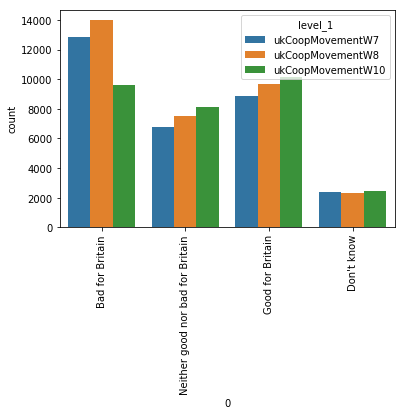

In [24]:
sns.countplot(x = 0, hue = "level_1", data = FreeMovement);
plt.xticks(rotation=90);

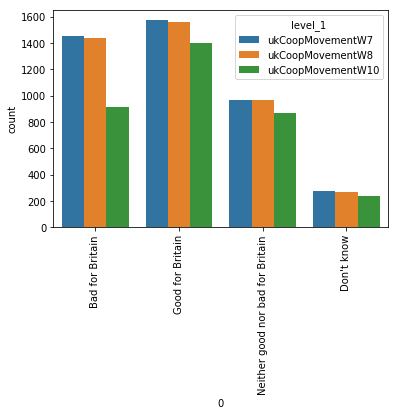

In [26]:
Scotland = BES_Panel["country"]=="Scotland"

FreeMovement = BES_Panel[[x for x in BES_Panel.columns if "ukCoopMovement" in x]][Scotland].stack().reset_index().drop("level_0",axis=1)#
#.apply(lambda x: x.cat.codes).replace(2, 0.5).replace(-1,np.nan).mean()

sns.countplot(x = 0, hue = "level_1", data = FreeMovement);
plt.xticks(rotation=90);